In [1]:
import torch
torch.__version__

'2.6.0+cu126'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

###############################################
# Dataset for Original Images and 3-Channel Masks
###############################################

class LVCombinedDataset(Dataset):
    """
    Dataset that loads a single grayscale image from the image directory and its corresponding
    three masks from three sub-folders (Lobe_1, Lobe_2, Lobe_3) inside the mask directory.

    The grayscale image is replicated to create a 3-channel input.
    The masks from each subfolder are stacked to form a 3-channel mask.

    Args:
        image_dir (str): Directory containing original images.
        mask_parent_dir (str): Parent directory containing subfolders:
            - Lobe_1
            - Lobe_2
            - Lobe_3
        file_list (list of str): List of filenames (assumed to be identical in image_dir).
        target_size (tuple): (width, height) for resizing images and masks.
    """
    def __init__(self, image_dir, mask_parent_dir, file_list, target_size=(416, 480)):
        self.image_dir = image_dir
        self.mask1_dir = os.path.join(mask_parent_dir, "Lobe_1")
        self.mask2_dir = os.path.join(mask_parent_dir, "Lobe_2")
        self.mask3_dir = os.path.join(mask_parent_dir, "Lobe_3")
        self.file_list = file_list
        self.target_size = target_size  # (width, height)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]

        # Load original image (grayscale)
        img_path = os.path.join(self.image_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Could not load image: {img_path}")
        # Resize and normalize the image
        img = cv2.resize(img, self.target_size)
        img = img.astype(np.float32) / 255.0
        # Replicate the grayscale image into 3 channels
        img = np.stack([img, img, img], axis=0)

        # Construct the mask filename by inserting '_gt' before the file extension.
        base, ext = os.path.splitext(filename)
        mask_filename = base + "_gt" + ext

        # Load the three mask images from their respective sub-folders
        mask1_path = os.path.join(self.mask1_dir, mask_filename)
        mask2_path = os.path.join(self.mask2_dir, mask_filename)
        mask3_path = os.path.join(self.mask3_dir, mask_filename)

        mask1 = cv2.imread(mask1_path, cv2.IMREAD_GRAYSCALE)
        mask2 = cv2.imread(mask2_path, cv2.IMREAD_GRAYSCALE)
        mask3 = cv2.imread(mask3_path, cv2.IMREAD_GRAYSCALE)
        if mask1 is None or mask2 is None or mask3 is None:
            raise ValueError(f"Could not load one or more masks for file: {filename}")
        mask1 = cv2.resize(mask1, self.target_size)
        mask2 = cv2.resize(mask2, self.target_size)
        mask3 = cv2.resize(mask3, self.target_size)
        # Binarize the masks (assuming a threshold of 127)
        mask1 = (mask1 > 127).astype(np.float32)
        mask2 = (mask2 > 127).astype(np.float32)
        mask3 = (mask3 > 127).astype(np.float32)
        # Stack masks to form a 3-channel mask
        mask = np.stack([mask1, mask2, mask3], axis=0)

        # Convert to torch tensors
        img_tensor = torch.tensor(img, dtype=torch.float32)
        mask_tensor = torch.tensor(mask, dtype=torch.float32)

        return img_tensor, mask_tensor

###############################################
# Prepare File Lists and DataLoaders
###############################################

# Define parent directories for images and masks
image_dir = r"F:\Rohit\LRP\Custom_Unet\Dataset\img_480_416"
mask_parent_dir  = r"F:\Rohit\LRP\Custom_Unet\Dataset\segmented_output"

# List files from the image_dir
supported_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tif')
all_files = [f for f in os.listdir(image_dir) if f.lower().endswith(supported_extensions)]

# Filter out files that do not have corresponding masks in all three subfolders.
valid_files = []
for f in all_files:
    base, ext = os.path.splitext(f)
    mask_filename = base + "_gt" + ext

    mask1_path = os.path.join(mask_parent_dir, "Lobe_1", mask_filename)
    mask2_path = os.path.join(mask_parent_dir, "Lobe_2", mask_filename)
    mask3_path = os.path.join(mask_parent_dir, "Lobe_3", mask_filename)
    if os.path.exists(mask1_path) and os.path.exists(mask2_path) and os.path.exists(mask3_path):
        valid_files.append(f)
    else:
        print(f"Skipping {f}: One or more mask files not found.")

print("Valid samples:", len(valid_files))

# Split file list into training and validation sets
train_files, val_files = train_test_split(valid_files, test_size=0.2, random_state=42)
print("Train samples:", len(train_files), "Validation samples:", len(val_files))

# Define target size as (width, height)
target_size = (416, 480)

# Create dataset objects
train_dataset = LVCombinedDataset(image_dir, mask_parent_dir, train_files, target_size=target_size)
val_dataset   = LVCombinedDataset(image_dir, mask_parent_dir, val_files, target_size=target_size)

# Custom collate function to filter out None values if necessary
def safe_collate(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None, None
    return torch.utils.data.default_collate(batch)

# Create DataLoaders
train_loader = DataLoader(train_dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=0,
                          collate_fn=safe_collate)
val_loader   = DataLoader(val_dataset,
                          batch_size=4,
                          shuffle=False,
                          num_workers=0,
                          collate_fn=safe_collate)

# Check one batch
img, mask = next(iter(train_loader))
print("Input batch shape:", img.shape)  # Expected: [batch_size, 3, H, W]
print("Mask batch shape:", mask.shape)   # Expected: [batch_size, 3, H, W]


Valid samples: 2000
Train samples: 1600 Validation samples: 400
Input batch shape: torch.Size([4, 3, 480, 416])
Mask batch shape: torch.Size([4, 3, 480, 416])


In [6]:
print("Training Files:", train_files)
print("Validation Files:", val_files)


Training Files: ['patient0243_2CH_ED.png', 'patient0061_2CH_ED.png', 'patient0205_4CH_ES.png', 'patient0174_2CH_ED.png', 'patient0106_2CH_ED.png', 'patient0272_2CH_ES.png', 'patient0500_4CH_ED.png', 'patient0092_2CH_ES.png', 'patient0256_4CH_ED.png', 'patient0311_2CH_ED.png', 'patient0148_2CH_ED.png', 'patient0185_2CH_ED.png', 'patient0441_2CH_ES.png', 'patient0236_2CH_ES.png', 'patient0018_4CH_ES.png', 'patient0352_4CH_ES.png', 'patient0065_4CH_ES.png', 'patient0013_4CH_ES.png', 'patient0050_4CH_ED.png', 'patient0448_2CH_ED.png', 'patient0163_4CH_ED.png', 'patient0084_2CH_ED.png', 'patient0340_4CH_ES.png', 'patient0149_2CH_ES.png', 'patient0348_4CH_ES.png', 'patient0451_2CH_ED.png', 'patient0329_4CH_ED.png', 'patient0278_4CH_ES.png', 'patient0252_4CH_ED.png', 'patient0332_4CH_ED.png', 'patient0107_4CH_ED.png', 'patient0390_4CH_ED.png', 'patient0324_2CH_ES.png', 'patient0148_4CH_ED.png', 'patient0490_2CH_ES.png', 'patient0495_2CH_ED.png', 'patient0284_2CH_ED.png', 'patient0247_2CH_ES.p

In [7]:
img, mask = next(iter(train_loader))
img.shape, mask.shape

(torch.Size([4, 3, 480, 416]), torch.Size([4, 3, 480, 416]))

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.01, inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )
    def forward(self, x):
        return self.block(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
        self.conv = ConvBlock(out_channels * 2, out_channels)
    def forward(self, x, skip):
        x = self.up(x)
        # Ensure the dimensions match (in case of odd input sizes)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class nnUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_filters=32):
        super().__init__()
        self.in_conv = ConvBlock(in_channels, base_filters)
        self.down1 = DownBlock(base_filters, base_filters * 2)
        self.down2 = DownBlock(base_filters * 2, base_filters * 4)
        self.down3 = DownBlock(base_filters * 4, base_filters * 8)
        self.down4 = DownBlock(base_filters * 8, base_filters * 16)
        self.up1 = UpBlock(base_filters * 16, base_filters * 8)
        self.up2 = UpBlock(base_filters * 8, base_filters * 4)
        self.up3 = UpBlock(base_filters * 4, base_filters * 2)
        self.up4 = UpBlock(base_filters * 2, base_filters)
        self.out_conv = nn.Conv2d(base_filters, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x_up1 = self.up1(x5, x4)
        x_up2 = self.up2(x_up1, x3)
        x_up3 = self.up3(x_up2, x2)
        x_up4 = self.up4(x_up3, x1)
        pre_output = x_up4  # Features before final convolution
        output = self.out_conv(pre_output)
        return output, pre_output

In [9]:
# Initialize the model
model = nnUNet(in_channels=3, out_channels=3).to(device)
print(model)

nnUNet(
  (in_conv): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (down1): DownBlock(
    (block): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), str

In [10]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

#[batch_size, 3, height, width]
summary(model, input_size=[4, 3, 416, 480])

Layer (type:depth-idx)                             Output Shape              Param #
nnUNet                                             [4, 3, 416, 480]          --
├─ConvBlock: 1-1                                   [4, 32, 416, 480]         --
│    └─Sequential: 2-1                             [4, 32, 416, 480]         --
│    │    └─Conv2d: 3-1                            [4, 32, 416, 480]         896
│    │    └─InstanceNorm2d: 3-2                    [4, 32, 416, 480]         --
│    │    └─LeakyReLU: 3-3                         [4, 32, 416, 480]         --
│    │    └─Conv2d: 3-4                            [4, 32, 416, 480]         9,248
│    │    └─InstanceNorm2d: 3-5                    [4, 32, 416, 480]         --
│    │    └─LeakyReLU: 3-6                         [4, 32, 416, 480]         --
├─DownBlock: 1-2                                   [4, 64, 208, 240]         --
│    └─Sequential: 2-2                             [4, 64, 208, 240]         --
│    │    └─MaxPool2d: 3-7     

In [11]:
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

def compute_accuracy(outputs, masks):
    """
    Computes pixel-wise accuracy for binary segmentation.

    Args:
        outputs (Tensor or tuple): Raw logits from the network. If tuple,
                                   assumes the first element is the main output.
        masks (Tensor): Ground truth binary masks.

    Returns:
        float: Pixel accuracy.
    """
    # If deep supervision is enabled, use only the main output.
    if isinstance(outputs, tuple):
        main_output = outputs[0]
    else:
        main_output = outputs

    # Convert logits to probabilities and then to binary predictions.
    probs = torch.sigmoid(main_output)
    preds = (probs > 0.5).float()
    correct = (preds == masks).float().sum()
    total = masks.numel()
    return correct / total

def compute_dice_score(outputs, masks, smooth=1e-8):
    """
    Computes Dice score for binary segmentation.

    Args:
        outputs (Tensor or tuple): Raw logits from the network. If tuple,
                                   assumes the first element is the main output.
        masks (Tensor): Ground truth binary masks.
        smooth (float): Smoothing factor to avoid division by zero.

    Returns:
        float: Dice score.
    """
    if isinstance(outputs, tuple):
        main_output = outputs[0]
    else:
        main_output = outputs

    probs = torch.sigmoid(main_output)
    intersection = (probs * masks).sum()
    dice_score = (2. * intersection + smooth) / (probs.sum() + masks.sum() + smooth)
    return dice_score

def train_step(model, dataloader, loss_fn, optimizer, device):
    """Train for one epoch and return average loss, dice score, and accuracy."""
    model.train()
    cur_loss = 0.0
    total_dice = 0.0
    total_acc = 0.0
    processed_batches = 0

    for batch in dataloader:
        if batch is None:
            continue  # Skip empty batches

        imgs, masks = batch
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)

        # Ensure outputs is a tensor, not a tuple
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        # Ensure masks and outputs have the same shape
        if outputs.shape != masks.shape:
            masks = torch.nn.functional.interpolate(masks, size=outputs.shape[2:], mode="nearest")

        # Compute loss
        loss = loss_fn(outputs, masks)

        # Compute Dice Score
        preds = torch.sigmoid(outputs)
        intersection = (preds * masks).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + masks.sum(dim=(2, 3))
        dice = (2. * intersection + 1e-8) / (union + 1e-8)
        dice = dice.mean().item()

        # Compute Accuracy
        preds_bin = (preds > 0.5).float()
        correct = (preds_bin == masks).sum()
        total = torch.numel(masks)
        accuracy = correct / total

        # Backward pass
        loss.backward()
        optimizer.step()

        cur_loss += loss.item()
        total_dice += dice
        total_acc += accuracy.item()
        processed_batches += 1

    if processed_batches == 0:
        return float("inf"), 0.0, 0.0

    return cur_loss / processed_batches, total_dice / processed_batches, total_acc / processed_batches


In [12]:
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F

def compute_accuracy(outputs, masks):
    """
    Computes pixel-wise accuracy for binary segmentation.
    If deep supervision is enabled (i.e., outputs is a tuple), uses only the main output.
    """
    if isinstance(outputs, tuple):
        main_output = outputs[0]
    else:
        main_output = outputs
    probs = torch.sigmoid(main_output)
    preds = (probs > 0.5).float()
    correct = (preds == masks).float().sum()
    total = masks.numel()
    return correct / total

def compute_dice_score(outputs, masks, smooth=1e-8):
    """
    Computes the Dice score for binary segmentation.
    If deep supervision is enabled (i.e., outputs is a tuple), uses only the main output.
    """
    if isinstance(outputs, tuple):
        main_output = outputs[0]
    else:
        main_output = outputs
    probs = torch.sigmoid(main_output)
    intersection = (probs * masks).sum()
    dice_score = (2. * intersection + smooth) / (probs.sum() + masks.sum() + smooth)
    return dice_score

def test_step(model, dataloader, loss_fn, device):
    """Evaluate the model and return average loss, dice score, and accuracy."""
    model.eval()
    cur_loss = 0.0
    total_dice = 0.0
    total_acc = 0.0
    valid_batches = 0

    with torch.no_grad():
        for batch in dataloader:
            if batch is None:
                continue  # Skip empty batches

            imgs, masks = batch
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)

            # Ensure outputs is a tensor, not a tuple
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            # Ensure masks and outputs have the same shape
            if outputs.shape != masks.shape:
                masks = torch.nn.functional.interpolate(masks, size=outputs.shape[2:], mode="nearest")

            # Compute loss
            loss = loss_fn(outputs, masks)

            # Compute Dice Score
            preds = torch.sigmoid(outputs)
            intersection = (preds * masks).sum(dim=(2, 3))
            union = preds.sum(dim=(2, 3)) + masks.sum(dim=(2, 3))
            dice = (2. * intersection + 1e-8) / (union + 1e-8)
            dice = dice.mean().item()

            # Compute Accuracy
            preds_bin = (preds > 0.5).float()
            correct = (preds_bin == masks).sum()
            total = torch.numel(masks)
            accuracy = correct / total

            cur_loss += loss.item()
            total_dice += dice
            total_acc += accuracy.item()
            valid_batches += 1

    if valid_batches == 0:
        return float("inf"), 0.0, 0.0

    return cur_loss / valid_batches, total_dice / valid_batches, total_acc / valid_batches


In [13]:
import torch
import torch.nn as nn

class HybridLoss(nn.Module):
    """
    A combination of Binary Cross-Entropy (BCE) loss and Dice loss for segmentation tasks.
    """
    def __init__(self, bce_weight=1.0, dice_weight=1.0):
        super(HybridLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight

    def forward(self, preds, targets):
        """
        Compute the hybrid loss.

        Args:
            preds (torch.Tensor): Model predictions (logits).
            targets (torch.Tensor): Ground truth masks.

        Returns:
            torch.Tensor: Weighted sum of BCE and Dice loss.
        """
        # Compute BCE Loss
        bce = self.bce_loss(preds, targets)

        # Compute Dice Loss
        preds = torch.sigmoid(preds)  # Convert logits to probabilities
        intersection = (preds * targets).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice_loss = 1 - (2. * intersection + 1e-8) / (union + 1e-8)
        dice_loss = dice_loss.mean()

        # Weighted sum of BCE and Dice loss
        return self.bce_weight * bce + self.dice_weight * dice_loss


In [14]:
import os
from tqdm.auto import tqdm
import torch

import os

def train(model, train_dataloader, val_dataloader, loss_fn, optimizer, scheduler, device, epochs, model_save_path):
    """Train and evaluate the model while storing loss, dice scores, and accuracy for visualization."""
    results = {
        "train_loss": [],
        "train_dice": [],
        "train_acc": [],
        "val_loss": [],
        "val_dice": [],
        "val_acc": []
    }

    best_val_loss = float("inf")

    for epoch in tqdm(range(epochs), desc="Training Progress"):
        train_loss, train_dice, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        val_loss, val_dice, val_acc = test_step(model, val_dataloader, loss_fn, device)

        print(
            f"Epoch {epoch + 1}: "
            f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}, Val Acc: {val_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_dice"].append(train_dice)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_dice"].append(val_dice)
        results["val_acc"].append(val_acc)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
            torch.save(model.state_dict(), model_save_path)
            print(f"✅ New best model saved at {model_save_path} with Val Loss: {val_loss:.4f}")

        # Update learning rate
        if scheduler:
            scheduler.step(val_loss)

    return results


In [15]:
model_save_path = r"F:\Rohit\LRP\Custom_Unet\cu_unet.pth"

# Optimizer and Scheduler Configuration
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

# Start Training
model_results = train(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    loss_fn=HybridLoss(bce_weight=1.0, dice_weight=1.0),
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=50,
    model_save_path=model_save_path
)


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Train Loss: 1.2613, Train Dice: 0.2418, Train Acc: 0.8814 | Val Loss: 1.1046, Val Dice: 0.2964, Val Acc: 0.9639
✅ New best model saved at F:\Rohit\LRP\Custom_Unet\cu_unet.pth with Val Loss: 1.1046
Epoch 2: Train Loss: 1.0058, Train Dice: 0.3276, Train Acc: 0.9714 | Val Loss: 0.9068, Val Dice: 0.3689, Val Acc: 0.9740
✅ New best model saved at F:\Rohit\LRP\Custom_Unet\cu_unet.pth with Val Loss: 0.9068
Epoch 3: Train Loss: 0.8313, Train Dice: 0.4027, Train Acc: 0.9757 | Val Loss: 0.7545, Val Dice: 0.4460, Val Acc: 0.9743
✅ New best model saved at F:\Rohit\LRP\Custom_Unet\cu_unet.pth with Val Loss: 0.7545
Epoch 4: Train Loss: 0.6840, Train Dice: 0.4837, Train Acc: 0.9789 | Val Loss: 0.6160, Val Dice: 0.5273, Val Acc: 0.9792
✅ New best model saved at F:\Rohit\LRP\Custom_Unet\cu_unet.pth with Val Loss: 0.6160
Epoch 5: Train Loss: 0.5634, Train Dice: 0.5617, Train Acc: 0.9803 | Val Loss: 0.5201, Val Dice: 0.5963, Val Acc: 0.9775
✅ New best model saved at F:\Rohit\LRP\Custom_Unet\cu_u

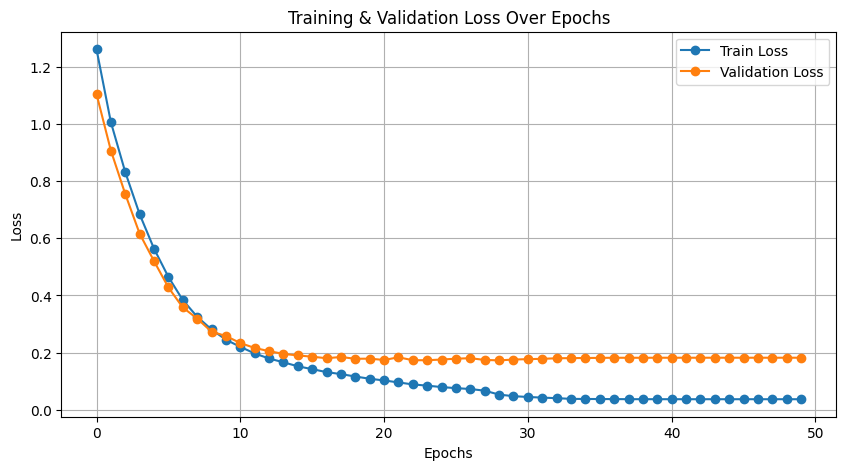

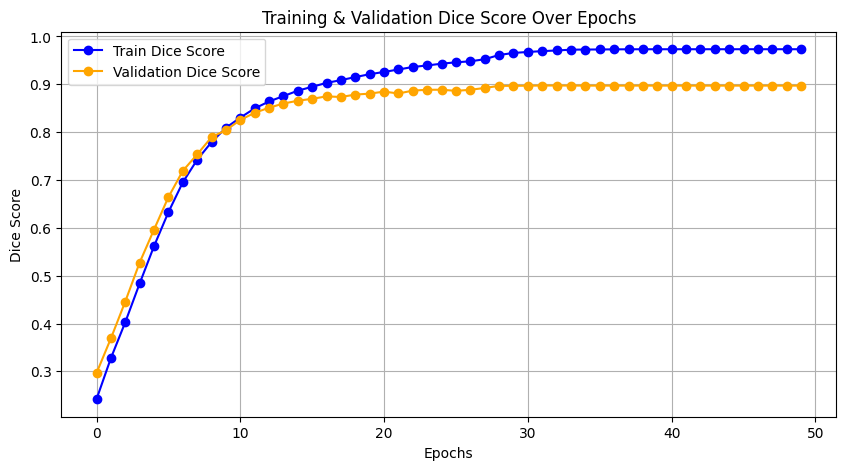

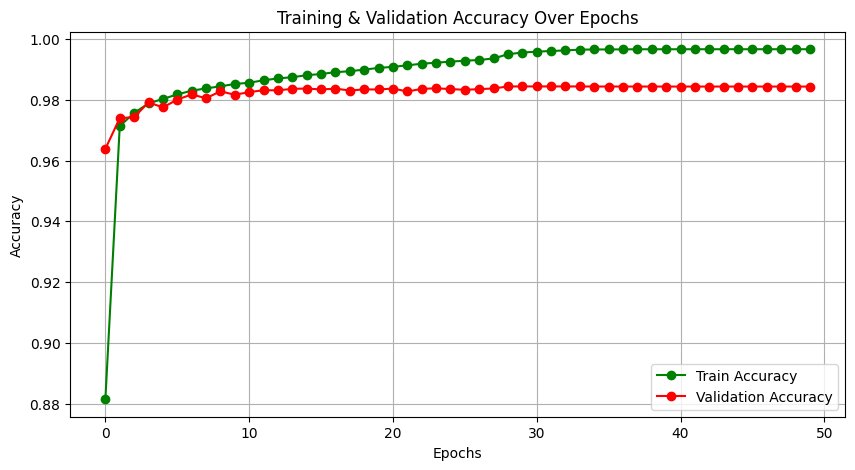

In [16]:
import matplotlib.pyplot as plt

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(model_results["train_loss"], label="Train Loss", marker='o')
plt.plot(model_results["val_loss"], label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Dice Score
plt.figure(figsize=(10, 5))
plt.plot(model_results["train_dice"], label="Train Dice Score", marker='o', color='blue')
plt.plot(model_results["val_dice"], label="Validation Dice Score", marker='o', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Dice Score")
plt.title("Training & Validation Dice Score Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(model_results["train_acc"], label="Train Accuracy", marker='o', color='green')
plt.plot(model_results["val_acc"], label="Validation Accuracy", marker='o', color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()


In [33]:
import os
import numpy as np
import cv2
import torch
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    mean_absolute_error
)

# ----------------------------------
# Metric functions (single-channel)
# ----------------------------------

def dice_coefficient(y_true, y_pred, smooth=1.0):
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred, smooth=1.0):
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def hausdorff_distance_single(y_true, y_pred, conversion_factor=0.5):
    coords_true = np.column_stack(np.where(y_true))
    coords_pred = np.column_stack(np.where(y_pred))
    if coords_true.size == 0 or coords_pred.size == 0:
        return np.nan
    d1 = directed_hausdorff(coords_true, coords_pred)[0]
    d2 = directed_hausdorff(coords_pred, coords_true)[0]
    return max(d1, d2) * conversion_factor

def mean_absolute_distance_single(y_true, y_pred,conversion_factor=0.5):
    mask_true = (y_true * 255).astype(np.uint8)
    mask_pred = (y_pred * 255).astype(np.uint8)
    cnts_true, _ = cv2.findContours(mask_true, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnts_pred, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not cnts_true or not cnts_pred:
        return np.nan * conversion_factor
    pts_true = np.vstack(cnts_true)[:,0,:]
    pts_pred = np.vstack(cnts_pred)[:,0,:]
    dists = []
    for pt in pts_true:
        dists.append(np.min(np.linalg.norm(pts_pred - pt, axis=1)))
    return np.mean(dists) * conversion_factor

def compute_classification_metrics(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    acc  = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec  = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    return acc, prec, rec

def compute_correlation(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return np.corrcoef(y_true_flat, y_pred_flat)[0,1]

# ----------------------------------
# Evaluation per-lobe
# ----------------------------------

def evaluate_model_by_lobes(model, dataloader, device, threshold=0.5):
    """
    model: your segmentation network returning a B×3×H×W logits tensor
    dataloader: yields (imgs, masks) with masks B×3×H×W binary
    """
    num_lobes = 3
    # prepare metric accumulators
    metrics = {
        'dice':      [[] for _ in range(num_lobes)],
        'jaccard':   [[] for _ in range(num_lobes)],
        'hausdorff': [[] for _ in range(num_lobes)],
        'mae':       [[] for _ in range(num_lobes)],
        'mad':       [[] for _ in range(num_lobes)],
        'acc':       [[] for _ in range(num_lobes)],
        'prec':      [[] for _ in range(num_lobes)],
        'rec':       [[] for _ in range(num_lobes)],
        'corr':      [[] for _ in range(num_lobes)],
    }

    model.eval()
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            if isinstance(logits, tuple):
                logits = logits[0]
            # Binarize preds & GT to {0,1}
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).float()
            preds_np = preds.cpu().numpy()
            masks_np = masks.cpu().numpy()

            # iterate batch & lobes
            B = preds_np.shape[0]
            for b in range(B):
                for l in range(num_lobes):
                    y_pred = preds_np[b, l]
                    y_true = masks_np[b, l]

                    # binarize GT in case it's float probs
                    y_true_bin = (y_true > threshold).astype(np.float32)

                    metrics['dice'][l].append(dice_coefficient(y_true_bin, y_pred))
                    metrics['jaccard'][l].append(jaccard_index(y_true_bin, y_pred))
                    metrics['hausdorff'][l].append(hausdorff_distance_single(y_true_bin, y_pred))
                    metrics['mae'][l].append(mean_absolute_error(y_true_bin.flatten(), y_pred.flatten()))
                    metrics['mad'][l].append(mean_absolute_distance_single(y_true_bin, y_pred))
                    a,p,r = compute_classification_metrics(y_true_bin, y_pred)
                    metrics['acc'][l].append(a)
                    metrics['prec'][l].append(p)
                    metrics['rec'][l].append(r)
                    metrics['corr'][l].append(compute_correlation(y_true_bin, y_pred))

    # Print summary per lobe
    for l in range(num_lobes):
        print(f"=== Lobe {l+1} Metrics ===")
        for name, vals in metrics.items():
            arr = np.array(vals[l], dtype=np.float32)
            mean = np.nanmean(arr)
            std  = np.nanstd(arr)
            print(f"{name.capitalize():<10}: {mean:.4f} ± {std:.4f}")
        print()

# ----------------------------------
# Load model, DataLoader, and run
# ----------------------------------

# 1) Instantiate your model and load weights
model = nnUNet(3,3,32)
checkpoint_path = r"F:\Rohit\LRP\Custom_Unet\cu_unet.pth"  # adjust as needed
model.load_state_dict(torch.load(checkpoint_path, map_location="cpu"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 2) Re-create your val_loader exactly as during training
#    (make sure it yields masks with shape B×3×H×W)

# 3) Run evaluation
evaluate_model_by_lobes(model, val_loader, device)


=== Lobe 1 Metrics ===
Dice      : 0.9355 ± 0.0356
Jaccard   : 0.8808 ± 0.0594
Hausdorff : 9.2740 ± 7.9175
Mae       : 0.0113 ± 0.0069
Mad       : 2.1406 ± 1.1578
Acc       : 0.9887 ± 0.0069
Prec      : 0.9396 ± 0.0555
Rec       : 0.9358 ± 0.0554
Corr      : 0.9305 ± 0.0363

=== Lobe 2 Metrics ===
Dice      : 0.8707 ± 0.0501
Jaccard   : 0.7743 ± 0.0735
Hausdorff : 10.6167 ± 9.1671
Mae       : 0.0258 ± 0.0130
Mad       : 2.1592 ± 0.7858
Acc       : 0.9742 ± 0.0130
Prec      : 0.8694 ± 0.0718
Rec       : 0.8765 ± 0.0576
Corr      : 0.8576 ± 0.0545

=== Lobe 3 Metrics ===
Dice      : 0.8984 ± 0.0811
Jaccard   : 0.8239 ± 0.1144
Hausdorff : 10.6265 ± 12.8636
Mae       : 0.0096 ± 0.0067
Mad       : 2.1893 ± 1.2581
Acc       : 0.9904 ± 0.0067
Prec      : 0.8996 ± 0.1078
Rec       : 0.9098 ± 0.0916
Corr      : 0.8968 ± 0.0782



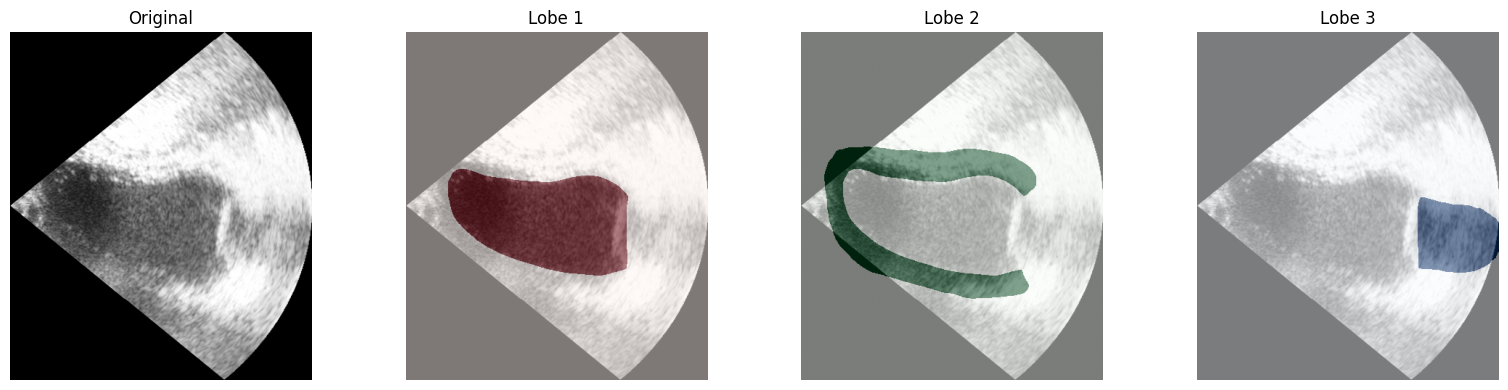

In [37]:
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ----------------------------------------
# 1) nnUNet definition (ConvBlock, DownBlock, UpBlock, nnUNet)
# ----------------------------------------
class ConvBlock(torch.nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_ch, out_ch, 3, padding=1),
            torch.nn.InstanceNorm2d(out_ch),
            torch.nn.LeakyReLU(0.01, inplace=True),
            torch.nn.Conv2d(out_ch, out_ch, 3, padding=1),
            torch.nn.InstanceNorm2d(out_ch),
            torch.nn.LeakyReLU(0.01, inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class DownBlock(torch.nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = torch.nn.Sequential(
            torch.nn.MaxPool2d(2),
            ConvBlock(in_ch, out_ch),
        )
    def forward(self, x):
        return self.block(x)

class UpBlock(torch.nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up   = torch.nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.conv = ConvBlock(out_ch * 2, out_ch)
    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=True)
        return self.conv(torch.cat([x, skip], dim=1))

class nnUNet(torch.nn.Module):
    def __init__(self, in_chan=3, out_chan=3, base_f=32):
        super().__init__()
        self.in_conv  = ConvBlock(in_chan, base_f)
        self.down1    = DownBlock(base_f, base_f*2)
        self.down2    = DownBlock(base_f*2, base_f*4)
        self.down3    = DownBlock(base_f*4, base_f*8)
        self.down4    = DownBlock(base_f*8, base_f*16)
        self.up1      = UpBlock(base_f*16, base_f*8)
        self.up2      = UpBlock(base_f*8,  base_f*4)
        self.up3      = UpBlock(base_f*4,  base_f*2)
        self.up4      = UpBlock(base_f*2,  base_f)
        self.out_conv = torch.nn.Conv2d(base_f, out_chan, kernel_size=1)

    def forward(self, x):
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        u1 = self.up1(x5, x4)
        u2 = self.up2(u1, x3)
        u3 = self.up3(u2, x2)
        u4 = self.up4(u3, x1)
        return self.out_conv(u4)  # logits shape: B×3×H×W

# ----------------------------------------
# 2) Preprocessing helper for .png inputs
# ----------------------------------------
def load_and_preprocess_png(path, target_size=(416,480)):
    """
    Loads a grayscale PNG, resizes to target_size (W,H), 
    normalizes to [0,1], replicates to 3 channels and returns a tensor.
    """
    gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if gray is None:
        raise FileNotFoundError(f"Could not load image: {path}")
    gray = cv2.resize(gray, target_size)
    gray = gray.astype(np.float32) / 255.0
    img3 = np.stack([gray, gray, gray], axis=0)  # 3×H×W
    tensor = torch.from_numpy(img3).unsqueeze(0)  # 1×3×H×W
    return tensor

# ----------------------------------------
# 3) Inference + visualization
# ----------------------------------------
def main():
    # Paths
    model_path = r"F:\Rohit\LRP\Custom_Unet\cu_unet.pth"
    image_path = r"F:\Rohit\LRP\Custom_Unet\Dataset\img_480_416\patient0001_2CH_ED.png"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Load model
    model = nnUNet(in_chan=3, out_chan=3, base_f=32)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()

    # 2) Load and preprocess PNG
    img_tensor = load_and_preprocess_png(image_path, target_size=(416,480)).to(device)

    # 3) Inference
    with torch.no_grad():
        logits = model(img_tensor)               # 1×3×416×480
        probs  = torch.sigmoid(logits)[0]        # 3×H×W
        masks  = (probs > 0.5).cpu().numpy().astype(np.uint8)  # 3×H×W

    # 4) Visualization side-by-side
    orig = img_tensor[0].cpu().numpy().transpose(1,2,0)  # H×W×3
    fig, axes = plt.subplots(1, 4, figsize=(16,4))
    axes[0].imshow(orig, cmap='gray')
    axes[0].set_title("Original")
    axes[0].axis('off')
    cmap_list = ["Reds", "Greens", "Blues"]
    for i in range(3):
        axes[i+1].imshow(orig, cmap='gray')
        axes[i+1].imshow(masks[i], cmap=cmap_list[i], alpha=0.5)
        axes[i+1].set_title(f"Lobe {i+1}")
        axes[i+1].axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


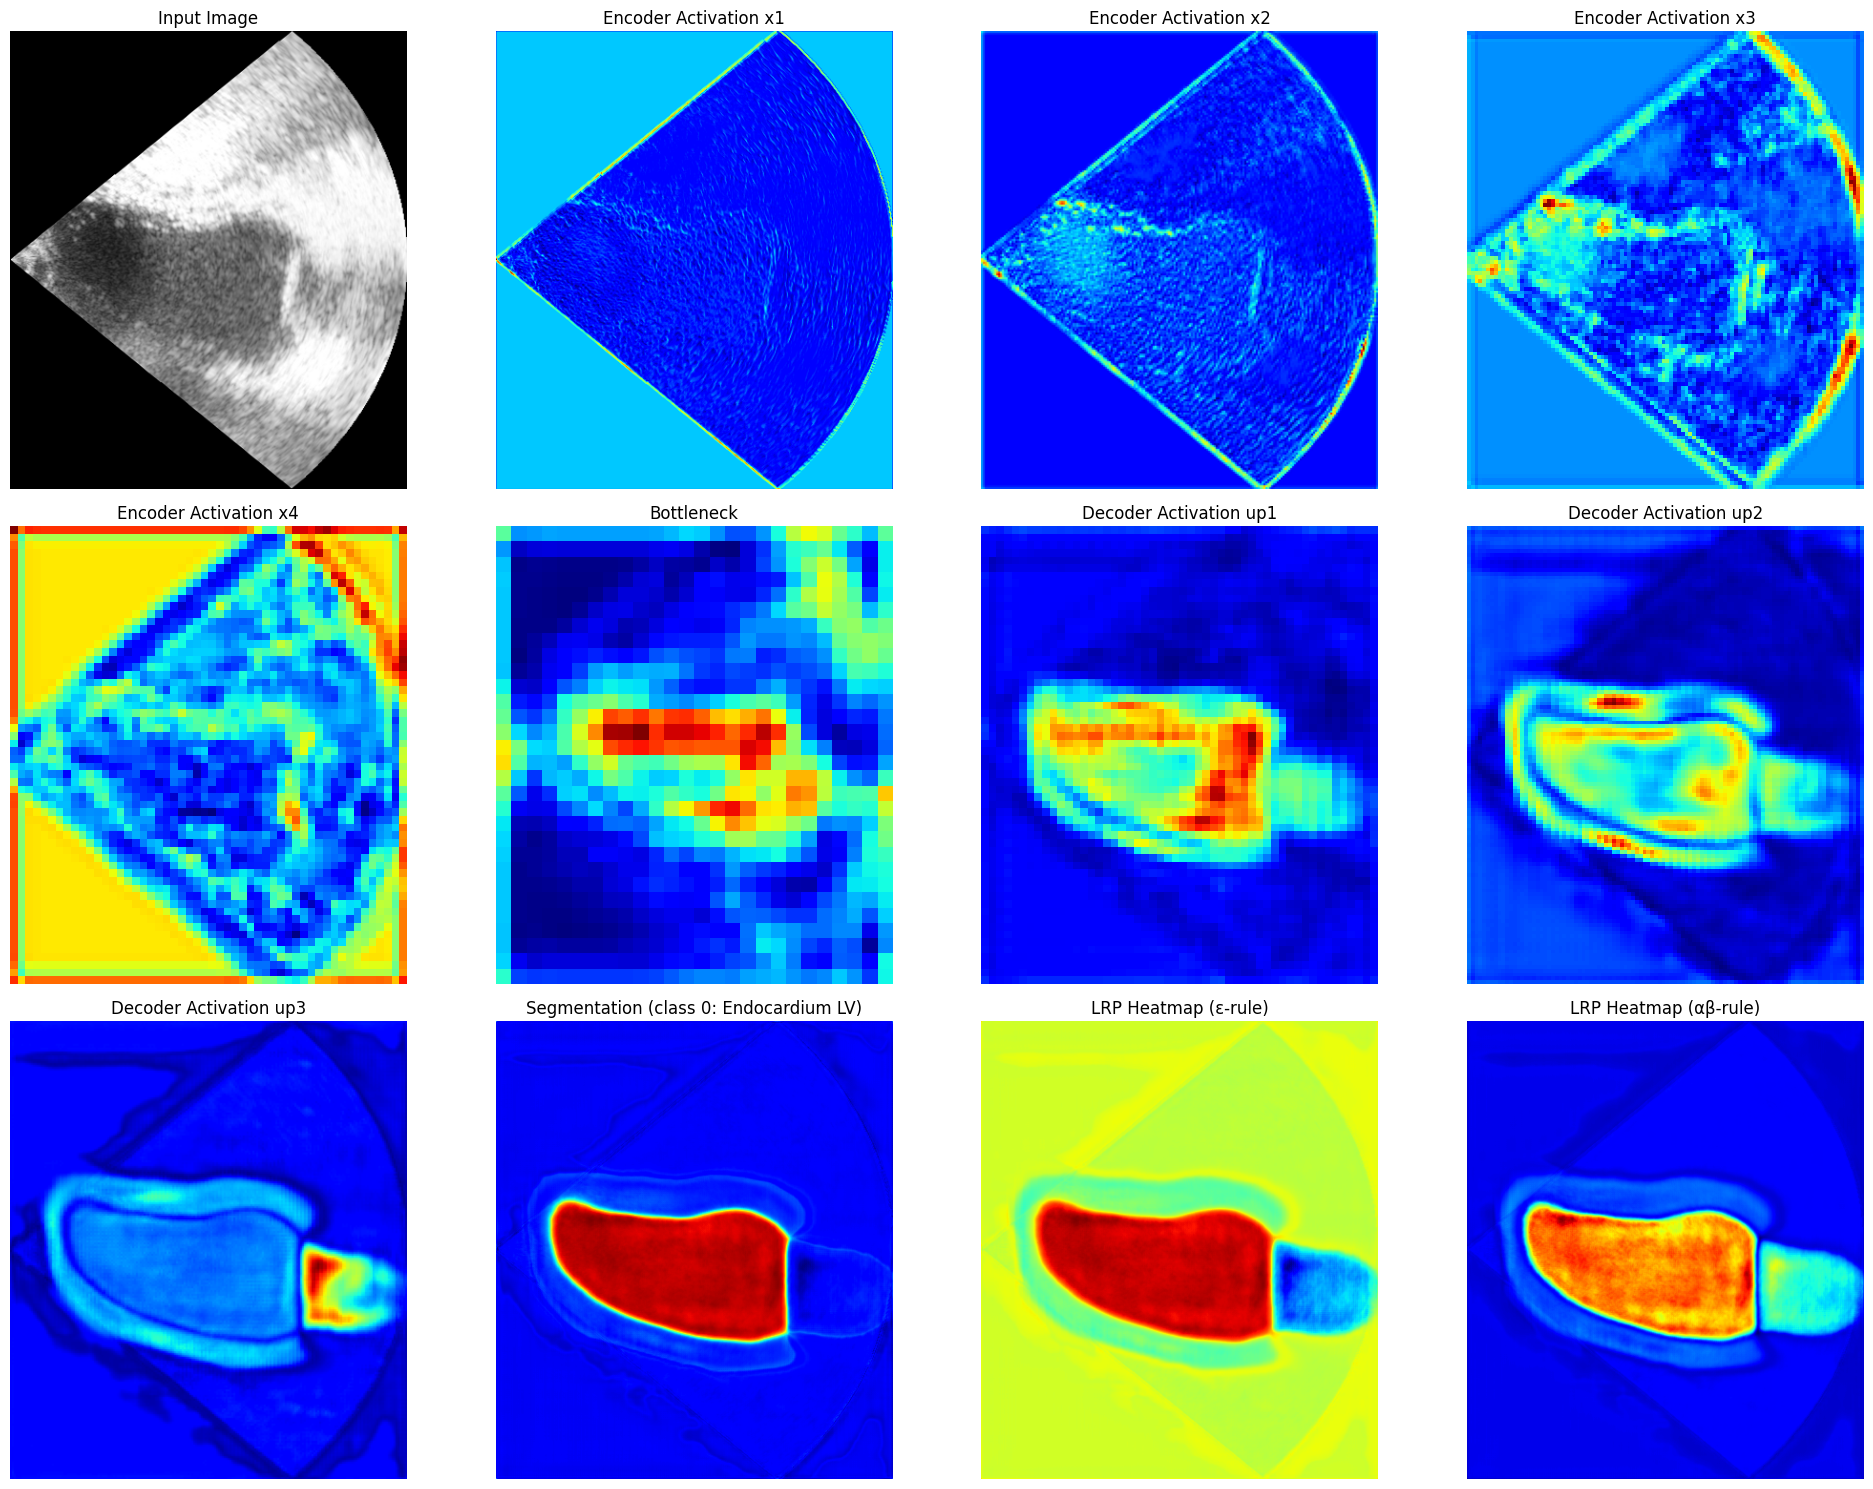

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ----------------------------
# Modified nnU-Net Model Definition with Bottleneck and Decoder Activations
# ----------------------------
class nnUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_filters=32):
        super().__init__()
        self.in_conv = ConvBlock(in_channels, base_filters)
        self.down1 = DownBlock(base_filters, base_filters * 2)
        self.down2 = DownBlock(base_filters * 2, base_filters * 4)
        self.down3 = DownBlock(base_filters * 4, base_filters * 8)
        self.down4 = DownBlock(base_filters * 8, base_filters * 16)
        self.up1 = UpBlock(base_filters * 16, base_filters * 8)
        self.up2 = UpBlock(base_filters * 8, base_filters * 4)
        self.up3 = UpBlock(base_filters * 4, base_filters * 2)
        self.up4 = UpBlock(base_filters * 2, base_filters)
        self.out_conv = nn.Conv2d(base_filters, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder path with intermediate activations.
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)  # Deepest activation (bottleneck).

        # Decoder path with skip connections.
        x_up1 = self.up1(x5, x4)
        x_up2 = self.up2(x_up1, x3)
        x_up3 = self.up3(x_up2, x2)
        x_up4 = self.up4(x_up3, x1)

        pre_output = x_up4  # Activation just before the final convolution.
        output = self.out_conv(pre_output)

        # Package activations for visualization.
        enc_activations = {
            'x1': x1,
            'x2': x2,
            'x3': x3,
            'x4': x4,
        }
        bottleneck = x5  # Deepest representation.
        dec_activations = {
            'up1': x_up1,
            'up2': x_up2,
            'up3': x_up3,
            'up4': x_up4,
        }
        return output, pre_output, enc_activations, bottleneck, dec_activations

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.01, inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.block(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
        self.conv = ConvBlock(out_channels * 2, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

# ----------------------------
# Simplified LRP Rules (Examples)
# ----------------------------
def lrp_epsilon_conv(layer, input_activation, relevance, epsilon=1e-2):
    """
    LRP for a convolutional layer using the ε-rule.
    Computes: z = layer(input_activation) + epsilon, then backprojects relevance.
    """
    z = layer(input_activation) + epsilon  # Forward pass with stability term.
    s = relevance / z
    c = torch.autograd.grad(z, input_activation, s, retain_graph=True)[0]
    return input_activation * c

def lrp_alpha_beta(layer, input_activation, relevance, alpha=1, beta=0):
    """
    Simplified LRP αβ-rule.
    Computes separate contributions from positive and negative parts.
    """
    z = layer(input_activation)
    pos_z = torch.clamp(z, min=0)
    neg_z = torch.clamp(z, max=0)
    z_sum = pos_z + neg_z + 1e-6  # Avoid division by zero.
    s = relevance / z_sum
    c = torch.autograd.grad(z, input_activation, s, retain_graph=True)[0]
    return alpha * input_activation * torch.clamp(c, min=0) - beta * input_activation * torch.clamp(c, max=0)

def lrp_flat(_, input_activation, relevance):
    """
    LRP flat rule: distribute relevance evenly among input neurons.
    (The underscore indicates the layer is not used.)
    """
    return relevance * (input_activation / (input_activation.sum() + 1e-6))

# ----------------------------
# Utility Function to Load an Input Image from PNG
# ----------------------------
def load_image(image_path, target_size=(416, 480)):
    # Load image in RGB mode to ensure 3 channels.
    image = Image.open(image_path).convert("RGB")
    image = image.resize(target_size, Image.LANCZOS)
    image = np.array(image) / 255.0
    # Convert from HWC to CHW format.
    image = np.transpose(image, (2, 0, 1))
    # Add batch dimension: resulting shape will be (1, 3, H, W)
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
    return image

# ----------------------------
# Helper Function: Convert a Tensor to a Normalized Heatmap (numpy array)
# ----------------------------
def tensor_to_heatmap(tensor):
    # If tensor has multiple channels, average over the channel dimension.
    if tensor.ndim == 4:  # shape: [batch, channels, H, W]
        tensor = tensor.mean(dim=1, keepdim=True)
    heatmap = tensor.squeeze().detach().cpu().numpy()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    return heatmap

# ----------------------------
# Main Workflow: Forward Pass, LRP, and Visualization
# ----------------------------
def main():
    # Update these paths as needed.
    model_path = r'F:\Rohit\LRP\Custom_Unet\cu_unet.pth'
    image_path = r'F:\Rohit\LRP\Custom_Unet\Dataset\img_480_416\patient0001_2CH_ED.png'

    # Set the desired class id for segmentation visualization.
    # For example, class_id = 1 corresponds to the endocardium of the left ventricle.
    class_id = 0

    # Instantiate model with 3 input channels and 3 output channels (matching your checkpoint)
    model = nnUNet(in_channels=3, out_channels=3)
    # Load the checkpoint mapping CUDA tensors to CPU.
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()

    image = load_image(image_path, target_size=(416, 480))
    image.requires_grad = True

    # Forward pass: get final output, pre_output, encoder activations, bottleneck, and decoder activations.
    output, pre_output, enc_activations, bottleneck, dec_activations = model(image)

    # Create a one-hot relevance vector so that only the chosen class contributes.
    one_hot = torch.zeros_like(output)
    one_hot[:, class_id, :, :] = output[:, class_id, :, :]
    relevance = one_hot  # Use this as the initialization for LRP.

    # -------------------------
    # Compute LRP for the final convolution layer using the ε-rule
    # -------------------------
    relevance_pre_epsilon = lrp_epsilon_conv(model.out_conv, pre_output, relevance, epsilon=1e-2)
    # Use pre_output as the activation for the flat rule (shapes match).
    relevance_input_epsilon = lrp_flat(None, pre_output, relevance_pre_epsilon)

    # -------------------------
    # Compute LRP for the final convolution layer using the αβ-rule
    # -------------------------
    relevance_pre_alpha_beta = lrp_alpha_beta(model.out_conv, pre_output, relevance, alpha=0.8, beta=0.2)
    relevance_input_alpha_beta = lrp_flat(None, pre_output, relevance_pre_alpha_beta)

    # Convert final LRP relevance maps to heatmaps.
    heatmap_epsilon = tensor_to_heatmap(relevance_input_epsilon)
    heatmap_alpha_beta = tensor_to_heatmap(relevance_input_alpha_beta)

    # Get the segmentation output for the specified class.
    segmentation = output[:, class_id, :, :]
    segmentation_heatmap = tensor_to_heatmap(segmentation)

    # -------------------------
    # Visualization: Create a grid of 3 rows x 4 columns (12 subplots)
    # The grid now shows:
    # Row 1: Input, Encoder x1, Encoder x2, Encoder x3
    # Row 2: Encoder x4, Bottleneck, Decoder up1, Decoder up2
    # Row 3: Decoder up3, Segmentation Output (class_id), LRP Heatmap (ε-rule), LRP Heatmap (αβ-rule)
    # -------------------------
    fig, axs = plt.subplots(3, 4, figsize=(20, 15))
    axs = axs.flatten()

    # Row 1
    axs[0].imshow(tensor_to_heatmap(image), cmap='gray')
    axs[0].set_title("Input Image")
    axs[0].axis('off')

    axs[1].imshow(tensor_to_heatmap(enc_activations['x1']), cmap='jet')
    axs[1].set_title("Encoder Activation x1")
    axs[1].axis('off')

    axs[2].imshow(tensor_to_heatmap(enc_activations['x2']), cmap='jet')
    axs[2].set_title("Encoder Activation x2")
    axs[2].axis('off')

    axs[3].imshow(tensor_to_heatmap(enc_activations['x3']), cmap='jet')
    axs[3].set_title("Encoder Activation x3")
    axs[3].axis('off')

    # Row 2
    axs[4].imshow(tensor_to_heatmap(enc_activations['x4']), cmap='jet')
    axs[4].set_title("Encoder Activation x4")
    axs[4].axis('off')

    axs[5].imshow(tensor_to_heatmap(bottleneck), cmap='jet')
    axs[5].set_title("Bottleneck")
    axs[5].axis('off')

    axs[6].imshow(tensor_to_heatmap(dec_activations['up1']), cmap='jet')
    axs[6].set_title("Decoder Activation up1")
    axs[6].axis('off')

    axs[7].imshow(tensor_to_heatmap(dec_activations['up2']), cmap='jet')
    axs[7].set_title("Decoder Activation up2")
    axs[7].axis('off')

    # Row 3
    axs[8].imshow(tensor_to_heatmap(dec_activations['up3']), cmap='jet')
    axs[8].set_title("Decoder Activation up3")
    axs[8].axis('off')

    # Replace the decoder activation up4 plot with the segmentation output for the selected class.
    axs[9].imshow(segmentation_heatmap, cmap='jet')
    axs[9].set_title(f"Segmentation (class {class_id}: Endocardium LV)")
    axs[9].axis('off')

    axs[10].imshow(heatmap_epsilon, cmap='jet')
    axs[10].set_title("LRP Heatmap (ε-rule)")
    axs[10].axis('off')

    axs[11].imshow(heatmap_alpha_beta, cmap='jet')
    axs[11].set_title("LRP Heatmap (αβ-rule)")
    axs[11].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [45]:
import torch
import torch.nn.functional as F

def lrp_0(layer, input_activation, relevance, epsilon=1e-6):
    """
    LRP-0 rule:
      R_j <- Σ_i ( z_ji / (Σ_j z_ji + ε) ) * R_i
    where z_ji = w_ji * a_j.
    """
    # Forward pass
    z = layer(input_activation)
    
    # Compute the "distribution" factor
    s = relevance / (z + epsilon)
    
    # Backprop relevance
    c = torch.autograd.grad(z, input_activation, s, retain_graph=True)[0]
    return input_activation * c


def lrp_epsilon(layer, input_activation, relevance, epsilon=1e-6):
    """
    LRP-ε rule (epsilon rule):
      R_j <- Σ_i ( z_ji + ε·sign(z_ji) ) / (Σ_j z_ji + ε·sign(Σ_j z_ji)) * R_i
    We implement a simplified version:
      1) Forward pass to get z
      2) Add small epsilon * sign(z) to stabilize
      3) Distribute relevance
      4) Gradient w.r.t. original z
    """
    z = layer(input_activation)
    
    # Add a sign-based stabilizer
    sign_z = torch.where(z >= 0, torch.ones_like(z), -torch.ones_like(z))
    z_eps = z + epsilon * sign_z
    
    # Distribute relevance
    s = relevance / z_eps
    # Use gradient w.r.t. z (not z_eps), so we pass `z` below:
    c = torch.autograd.grad(z, input_activation, s, retain_graph=True)[0]
    return input_activation * c


def lrp_z_plus(layer, input_activation, relevance, epsilon=1e-6):
    """
    z+ (ε) rule:
      Only the positive contributions are considered in z.
      R_j <- Σ_i ( z_ji^+ / (Σ_j z_ji^+ + ε) ) * R_i
    """
    # Forward pass
    z = layer(input_activation)
    
    # Keep only positive contributions
    z_plus = torch.clamp(z, min=0)
    
    # Distribute relevance based on z+ only
    s = relevance / (z_plus + epsilon)
    
    # We take gradient wrt z_plus to zero-out negative paths
    c = torch.autograd.grad(z_plus, input_activation, s, retain_graph=True)[0]
    
    # Multiply by positive part of input as well (common variant)
    return torch.clamp(input_activation, min=0) * torch.clamp(c, min=0)


def lrp_gamma(layer, input_activation, relevance, gamma=0.5, epsilon=1e-6):
    """
    LRP-γ rule:
      Scales positive weights by (1+γ) to boost positive contributions.
    """
    # Temporarily modify layer weights for the forward pass
    W_original = layer.weight.data
    with torch.no_grad():
        W_modified = W_original.clone()
        # Scale only positive weights by (1 + gamma)
        W_modified[W_modified > 0] = W_modified[W_modified > 0] * (1.0 + gamma)
        layer.weight.data = W_modified
    
    # Forward pass with scaled weights
    z_mod = layer(input_activation)
    z_mod_plus = torch.clamp(z_mod, min=0)
    
    # Restore original weights
    layer.weight.data = W_original
    
    # Distribute relevance
    s = relevance / (z_mod_plus + epsilon)
    c = torch.autograd.grad(z_mod_plus, input_activation, s, retain_graph=True)[0]
    
    return torch.clamp(input_activation, min=0) * torch.clamp(c, min=0)


def lrp_alpha_beta(layer, input_activation, relevance, alpha=0.95, beta=0.5):
    """
    α-β rule (from your original code).
    """
    z = layer(input_activation)
    pos_z = torch.clamp(z, min=0)
    neg_z = torch.clamp(z, max=0)
    s = relevance / (pos_z + neg_z + 1e-6)
    c = torch.autograd.grad(z, input_activation, s, retain_graph=True)[0]
    return alpha * input_activation * torch.clamp(c, min=0) - beta * input_activation * torch.clamp(c, max=0)


def lrp_flat(layer, input_activation, relevance, seg_mask=None):
    """
    Flat rule + optional masking.
    """
    # 1. Forward pass (ignored, just for shape consistency).
    z = layer(input_activation)
    
    # 2. Compute total relevance (sum over output).
    B, outC, outH, outW = z.shape
    B, inC, H, W = input_activation.shape
    total_relevance = relevance.view(B, -1).sum(dim=1, keepdim=True)  # [B,1]
    
    # 3. Distribute uniformly across all input pixels.
    num_input_elements = inC * H * W
    flat_relevance = total_relevance / float(num_input_elements)
    flat_relevance = flat_relevance.view(B, 1, 1, 1).expand(B, inC, H, W)

    # 4. Optional: multiply by segmentation mask to blank out background
    if seg_mask is not None:
        # seg_mask should have shape [B, 1, H, W] or [B, inC, H, W].
        # If needed, broadcast seg_mask to match [B, inC, H, W].
        if seg_mask.shape[1] == 1 and inC > 1:
            seg_mask = seg_mask.expand(-1, inC, -1, -1)
        flat_relevance = flat_relevance * seg_mask
    
    return flat_relevance



def lrp_w_squared(layer, input_activation, relevance, epsilon=1e-6):
    """
    w² rule:
      Relevance is distributed proportionally to w².
    """
    W_original = layer.weight.data
    with torch.no_grad():
        W_modified = (W_original**2).clone()
        layer.weight.data = W_modified
    
    z_w2 = layer(input_activation)
    
    # Restore original weights
    layer.weight.data = W_original
    
    # Distribute relevance
    s = relevance / (z_w2 + epsilon)
    c = torch.autograd.grad(z_w2, input_activation, s, retain_graph=True)[0]
    
    return input_activation * c


def lrp_zB(layer, input_activation, relevance, l=0.0, h=1.0, epsilon=1e-6):
    """
    z^B rule (bounded rule).
    """
    z = layer(input_activation)
    
    W = layer.weight
    W_plus = torch.clamp(W, min=0)
    W_minus = torch.clamp(W, max=0)
    
    x_plus = torch.clamp(input_activation, min=0)
    x_minus = torch.clamp(input_activation, max=0)
    
    # zB = z - l·(x^+ * w^+) - h·(x^- * w^-)
    z_b = z
    z_b = z_b - l * F.conv2d(x_plus, W_plus, bias=None,
                             stride=layer.stride, padding=layer.padding)
    z_b = z_b - h * F.conv2d(x_minus, W_minus, bias=None,
                             stride=layer.stride, padding=layer.padding)
    
    s = relevance / (z_b + epsilon)
    c = torch.autograd.grad(z, input_activation, s, retain_graph=True)[0]
    
    return input_activation * c


In [46]:
# Suppose this is code3.py

lrp_0, lrp_epsilon, lrp_z_plus, lrp_gamma,
lrp_alpha_beta, lrp_flat, lrp_w_squared, lrp_zB

lrp_functions = {
    "LRP-0": lrp_0,
    "epsilon": lrp_epsilon,     # <-- Added here
    "z-plus": lrp_z_plus,
    "gamma": lrp_gamma,
    "alpha-beta": lrp_alpha_beta,
    "flat": lrp_flat,
    "w-squared": lrp_w_squared,
    "zB": lrp_zB
}


In [47]:
import numpy as np
import matplotlib.pyplot as plt

def overlay_seg_mask_on_image(image_np, mask_np, alpha=0.5, mask_color=(1, 0, 0)):
    """
    Overlays a binary mask on top of the original image.
      image_np: [H, W, 3], float in [0,1]
      mask_np:  [H, W], float (0 or 1) or something that can be thresholded
      alpha:    blending factor
      mask_color: (R, G, B) in [0,1]
    """
    # Ensure mask is binary or in [0,1]
    mask_bin = (mask_np > 0.5).astype(np.float32)
    
    # Convert mask to 3D color
    mask_3d = np.stack([mask_bin * c for c in mask_color], axis=-1)  # [H, W, 3]
    
    # Blend
    out = (1 - alpha) * image_np + alpha * mask_3d
    return np.clip(out, 0, 1)


def overlay_heatmap_on_image(image_np, heatmap_np, alpha=0.5, cmap='jet'):
    """
    Overlays a continuous heatmap (0..1) on top of the original image.
      image_np:   [H, W, 3], float in [0,1]
      heatmap_np: [H, W], float in [0,1]
      alpha:      blending factor
      cmap:       a matplotlib colormap name
    """
    cm = plt.get_cmap(cmap)
    colored_hm = cm(heatmap_np)[:, :, :3]  # RGBA -> take only RGB
    
    # Blend
    out = (1 - alpha) * image_np + alpha * colored_hm
    return np.clip(out, 0, 1)


In [48]:
import torch

def lrp_class_specific(relevance: torch.Tensor, class_idx: int) -> torch.Tensor:
    """
    Selects the relevance map for a single target class.

    Args:
        relevance: Tensor of shape (B, C, H, W) containing relevance for all C channels.
        class_idx: Index of the class/channel you want to explain.

    Returns:
        A Tensor of shape (B, 1, H, W) containing only the relevance for class_idx.
    """
    # Zero out all channels except the one for class_idx
    # and keep the channel dimension as 1
    return relevance[:, class_idx:class_idx + 1, :, :]

import torch

def apply_segmentation_mask(relevance: torch.Tensor,
                            seg_mask: torch.Tensor,
                            threshold: float = 0.3) -> torch.Tensor:
    """
    Zero out relevance values outside the segmented region.

    Args:
        relevance: Tensor of shape (B, 1, H, W) – your LRP relevance map.
        seg_mask:  Tensor of shape (B, 1, H, W) containing segmentation probabilities
                   or binary mask for the same image.
        threshold: Float in [0,1]. Pixels in seg_mask <= threshold will have their
                   relevance zeroed out.

    Returns:
        Tensor of same shape as `relevance`, masked by seg_mask.
    """
    # Ensure seg_mask is float tensor on same device
    seg_mask = seg_mask.to(relevance.device).float()
    # Create binary mask
    mask = (seg_mask > threshold).float()
    # Apply it
    return relevance * mask



Segmentation output stats: min = 2.547896292526275e-05 max = 0.999937891960144 mean = 0.09842473268508911


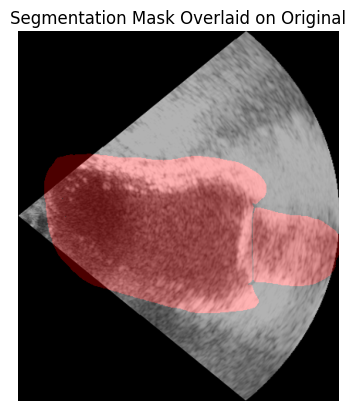


=== LRP Rule: LRP-0 ===
Relevance stats: min = -12.463382720947266 max = 1.5000314712524414 mean = -0.029800768941640854


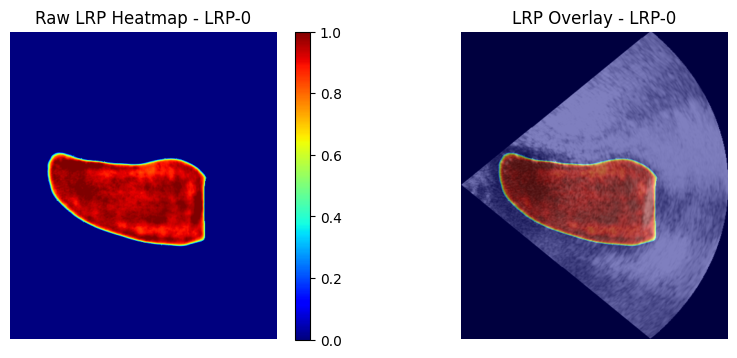


=== LRP Rule: epsilon ===
Relevance stats: min = -12.37352180480957 max = 1.5000314712524414 mean = -0.02980031445622444


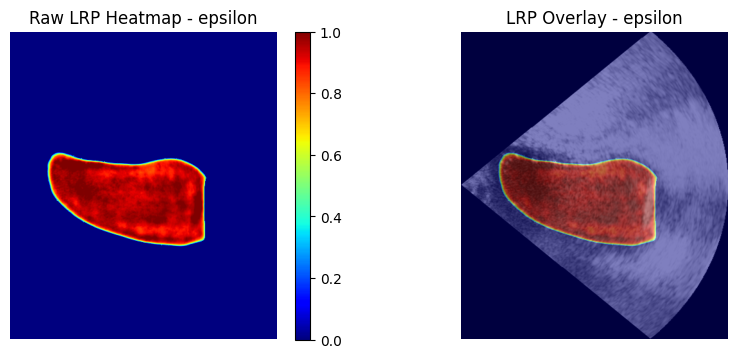


=== LRP Rule: z-plus ===
Relevance stats: min = 0.0 max = 7.640260696411133 mean = 0.029657535254955292


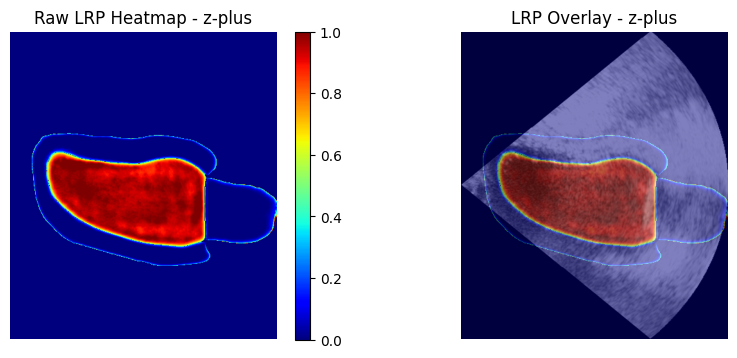


=== LRP Rule: gamma ===
Relevance stats: min = 0.0 max = 256.1192321777344 mean = 0.021209383383393288


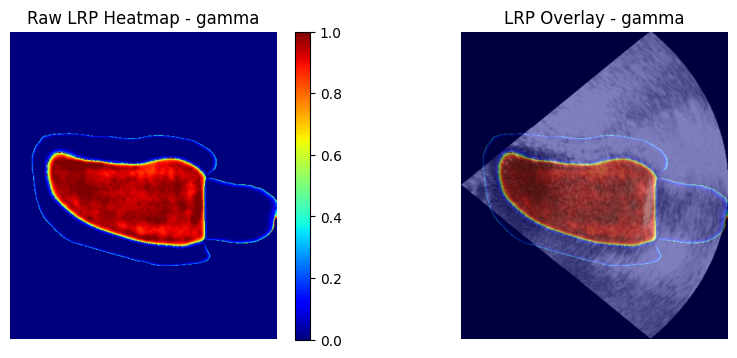


=== LRP Rule: alpha-beta ===
Relevance stats: min = 0.0 max = 82.03488159179688 mean = 0.12449146062135696


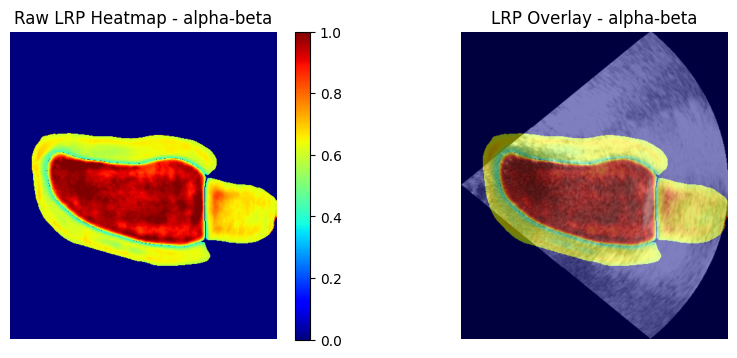


=== LRP Rule: flat ===
Relevance stats: min = -0.1988113522529602 max = 0.0 mean = -0.057328518480062485


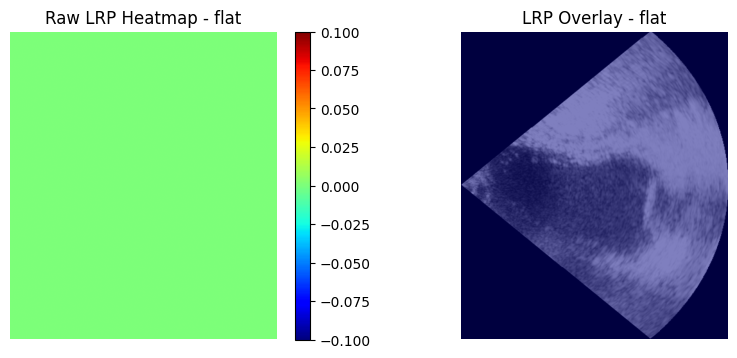


=== LRP Rule: w-squared ===
Relevance stats: min = -0.6096584796905518 max = 0.810960054397583 mean = -0.006297467742115259


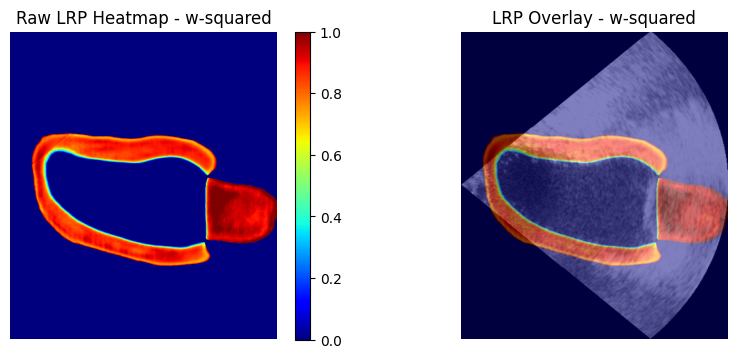


=== LRP Rule: zB ===
Relevance stats: min = -0.9545375108718872 max = 0.6528058648109436 mean = -0.029767222702503204


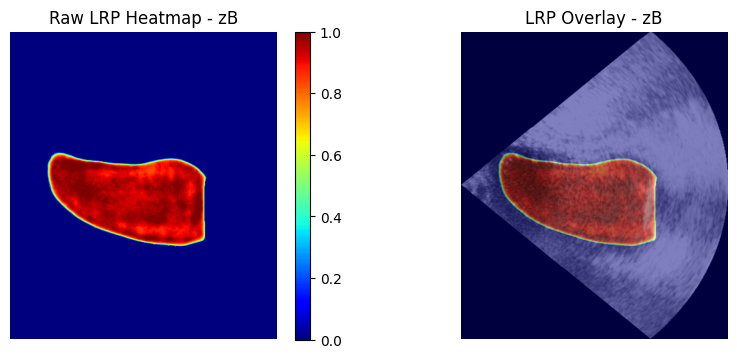

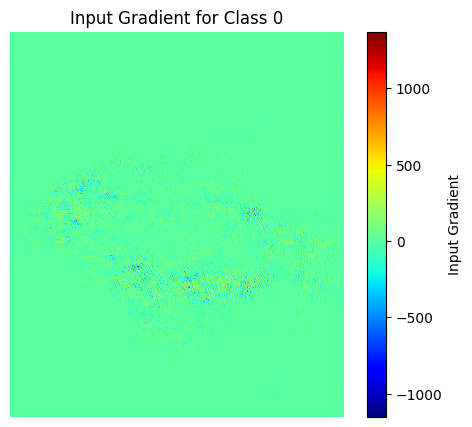

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt


def main():
    # ----------------------------
    # 1. Setup & Model Loading
    # ----------------------------
    model_path = r"F:\Rohit\LRP\Custom_Unet\cu_unet.pth"
    image_path = r"F:\Rohit\LRP\Custom_Unet\Dataset\img_480_416\patient0001_2CH_ED.png"

    model = nnUNet()
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
    model.eval()

    image = load_image(image_path, target_size=(416, 480))  # [1,3,H,W]
    image.requires_grad_(True)

    # Handle model output safely
    model_output = model(image)
    if isinstance(model_output, (tuple, list)):
        output = model_output[0]
        pre_output = model_output[1] if len(model_output) > 1 else None
    else:
        output = model_output
        pre_output = None

    segmentation_output = torch.sigmoid(output)

    print("Segmentation output stats:",
          "min =", segmentation_output.min().item(),
          "max =", segmentation_output.max().item(),
          "mean =", segmentation_output.mean().item())

    # Convert original image for visualization (shape: [H,W,3])
    orig_img_np = image[0].permute(1, 2, 0).detach().cpu().numpy()
    orig_img_np = np.clip(orig_img_np, 0, 1)

    # ----------------------------
    # 2. Visualize Segmentation Mask Overlay
    # ----------------------------
    seg_mask = (segmentation_output.mean(dim=1, keepdim=True) > 0.3).float()
    seg_mask_np = seg_mask[0, 0].detach().cpu().numpy()
    overlaid_seg = overlay_seg_mask_on_image(orig_img_np, seg_mask_np, alpha=0.3, mask_color=(1, 0, 0))
    plt.figure()
    plt.imshow(overlaid_seg)
    plt.title("Segmentation Mask Overlaid on Original")
    plt.axis("off")
    plt.show()

    # ----------------------------
    # 3. Run Each LRP Rule and Visualize Results
    # ----------------------------
    class_idx = 0  # Choose the output channel (class) to analyze
    for rule_name, lrp_fn in lrp_functions.items():
        print(f"\n=== LRP Rule: {rule_name} ===")
        relevance = output.detach().clone()  # [B, out_channels, H, W]
        relevance = lrp_class_specific(relevance, class_idx)  # [B,1,H,W]

        # Skip if no pre_output available
        if pre_output is None:
            print(f"Skipping {rule_name}: intermediate features not available.")
            continue

        # Apply rule
        if rule_name == "flat":
            relevance = lrp_fn(model.out_conv, pre_output, relevance, seg_mask=seg_mask)
        else:
            relevance = lrp_fn(model.out_conv, pre_output, relevance)

        # If multiple channels, average them
        if relevance.shape[1] > 1:
            relevance = relevance.mean(dim=1, keepdim=True)

        # Apply segmentation mask
        relevance = apply_segmentation_mask(relevance, seg_mask, threshold=0.3)
        print("Relevance stats:",
              "min =", relevance.min().item(),
              "max =", relevance.max().item(),
              "mean =", relevance.mean().item())

        # Normalize heatmap
        heatmap = relevance.detach().squeeze().cpu().numpy()
        p99 = np.percentile(heatmap, 99)
        heatmap = np.clip(heatmap, 0, p99)
        hm_min, hm_max = heatmap.min(), heatmap.max()
        if hm_max > hm_min:
            heatmap = (heatmap - hm_min) / (hm_max - hm_min)
        else:
            heatmap = np.zeros_like(heatmap)

        # Overlay and plot
        overlaid_hm = overlay_heatmap_on_image(orig_img_np, heatmap, alpha=0.5, cmap='jet')

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(heatmap, cmap='jet')
        plt.colorbar()
        plt.title(f"Raw LRP Heatmap - {rule_name}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(overlaid_hm)
        plt.title(f"LRP Overlay - {rule_name}")
        plt.axis("off")
        plt.show()

    # ----------------------------
    # 4. Input Gradient Visualization
    # ----------------------------
    model.zero_grad()
    output[0, class_idx].sum().backward(retain_graph=True)
    grad = image.grad.data[0, 0, :, :].cpu().numpy()
    plt.figure(figsize=(6, 5))
    plt.imshow(grad, cmap='jet')
    plt.colorbar(label="Input Gradient")
    plt.title(f"Input Gradient for Class {class_idx}")
    plt.axis("off")
    plt.show()



if __name__ == "__main__":
    main()


  Sparsity (90th pct):      0.1000 (10.0%)
  Localization IoU (90th):  0.3102 (31.0%)
  Faithfulness (corr):      0.4765 (47.7%)
  Stability (cos sim):      0.8457 (84.6%)


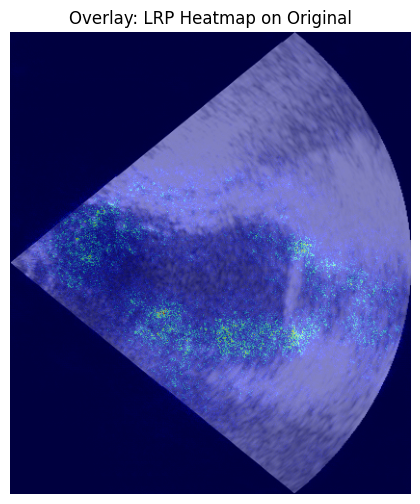

In [52]:
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# ----------------------------------------
# 1) Your nnUNet definition (unchanged)
# Add your ConvBlock, DownBlock, UpBlock, nnUNet here
# ----------------------------------------

# ----------------------------------------
# 2) I/O helpers
# ----------------------------------------
def load_image(path, target_size=(416,480)):
    gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    gray = cv2.resize(gray, target_size)
    gray = gray.astype(np.float32) / 255.0
    img3 = np.stack([gray, gray, gray], axis=0)
    return torch.from_numpy(img3).unsqueeze(0)  # 1×3×H×W

def load_mask_triplet(mask_parent_dir, filename, target_size=(416,480)):
    base, ext = os.path.splitext(filename)
    fname = base + "_gt" + ext
    masks = []
    for j in [1,2,3]:
        p = os.path.join(mask_parent_dir, f"Lobe_{j}", fname)
        m = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        m = cv2.resize(m, target_size)
        masks.append((m > 127).astype(np.uint8))
    combined = np.clip(masks[0] + masks[1] + masks[2], 0, 1)
    return combined  # H×W

# ----------------------------------------
# 3) Explainability metric functions
# ----------------------------------------
def compute_sparsity(heatmap, perc=90):
    thresh = np.percentile(heatmap, perc)
    return np.mean(heatmap >= thresh)

def compute_localization(heatmap, gt_mask, perc=90):
    thresh = np.percentile(heatmap, perc)
    bin_map = (heatmap >= thresh).astype(np.uint8)
    inter = np.logical_and(bin_map, gt_mask).sum()
    union = np.logical_or(bin_map, gt_mask).sum()
    return inter / union if union > 0 else 0.0

def compute_stability(model, image, class_idx, compute_heatmap_fn, noise_std=0.01, device='cpu'):
    orig = compute_heatmap_fn(model, image, class_idx, device=device)
    noise = image + torch.randn_like(image) * noise_std
    pert = compute_heatmap_fn(model, noise, class_idx, device=device)
    o_flat = orig.flatten()[None, :]
    p_flat = pert.flatten()[None, :]
    return cosine_similarity(o_flat, p_flat)[0, 0]

def compute_lrp_heatmap(model, image, class_idx=0, device='cpu'):
    model.to(device)
    image = image.to(device).clone().requires_grad_(True)
    output = model(image)
    if isinstance(output, (tuple, list)):
        out = output[0]
    else:
        out = output

    score = out[0, class_idx].sum()
    model.zero_grad()
    score.backward()
    grad = image.grad[0].detach().abs().mean(dim=0).cpu().numpy()
    mn, mx = grad.min(), grad.max()
    return (grad - mn) / (mx - mn + 1e-8)

# ----------------------------------------
# 4) Main script
# ----------------------------------------
def main():
    model_path      = r"F:\Rohit\LRP\Custom_Unet\cu_unet.pth"
    image_path      = r"F:\Rohit\LRP\Custom_Unet\Dataset\img_480_416\patient0001_2CH_ED.png"
    mask_parent_dir = r"F:\Rohit\LRP\Custom_Unet\Dataset\segmented_output"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model
    model = nnUNet()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Load image + combined mask
    img = load_image(image_path)  # 1×3×H×W
    gt = load_mask_triplet(mask_parent_dir, os.path.basename(image_path))  # H×W

    # Compute LRP heatmap
    heatmap = compute_lrp_heatmap(model, img, class_idx=0, device=device)

    # Get segmentation probability for class 0
    with torch.no_grad():
        model_output = model(img.to(device))
        logits = model_output[0] if isinstance(model_output, (tuple, list)) else model_output
        seg_prob = torch.sigmoid(logits)[0, 0].detach().cpu().numpy()

    # Compute explainability metrics
    sp   = compute_sparsity(heatmap, perc=90)
    loc  = compute_localization(heatmap, gt, perc=90)
    corr = np.corrcoef(heatmap.flatten(), seg_prob.flatten())[0, 1]
    stab = compute_stability(model, img, 0, compute_lrp_heatmap, noise_std=0.01, device=device)

    # Print results with percentages
    print(f"  Sparsity (90th pct):      {sp:.4f} ({sp*100:.1f}%)")
    print(f"  Localization IoU (90th):  {loc:.4f} ({loc*100:.1f}%)")
    print(f"  Faithfulness (corr):      {corr:.4f} ({corr*100:.1f}%)")
    print(f"  Stability (cos sim):      {stab:.4f} ({stab*100:.1f}%)")

    # Optional visualization
    orig = img[0].permute(1, 2, 0).cpu().numpy().clip(0, 1)
    plt.figure(figsize=(6, 6))
    plt.imshow(orig, cmap='gray')
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title("Overlay: LRP Heatmap on Original")
    plt.show()

if __name__ == "__main__":
    main()


Segmentation output stats: min = 2.547896292526275e-05 max = 0.999937891960144 mean = 0.09842473268508911


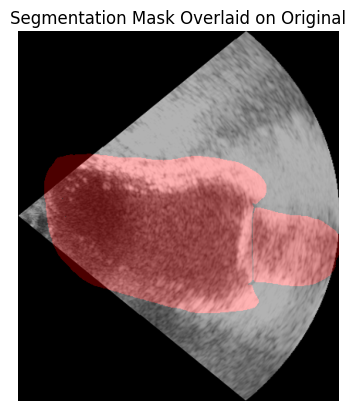


=== LRP Rule: LRP-0 ===
Relevance stats: min = -1.4603271484375 max = 1.9787311553955078 mean = -0.0642191544175148


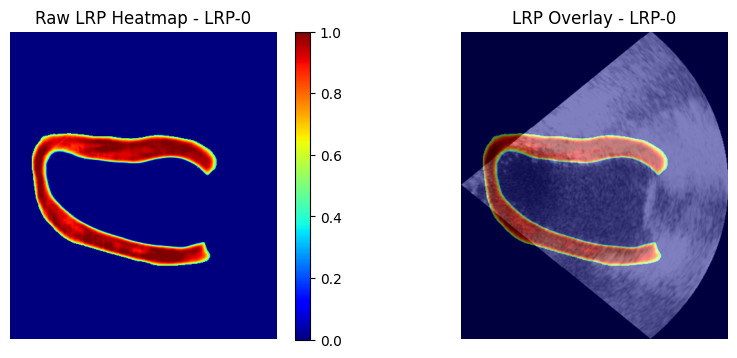


=== LRP Rule: epsilon ===
Relevance stats: min = -1.4591550827026367 max = 1.9787311553955078 mean = -0.06421913951635361


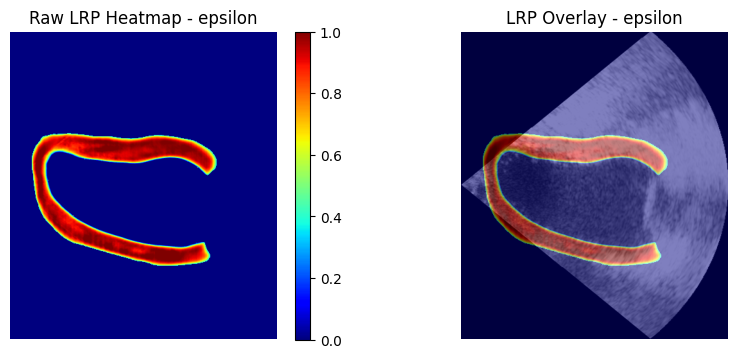


=== LRP Rule: z-plus ===
Relevance stats: min = 0.0 max = 16.833877563476562 mean = 0.023203061893582344


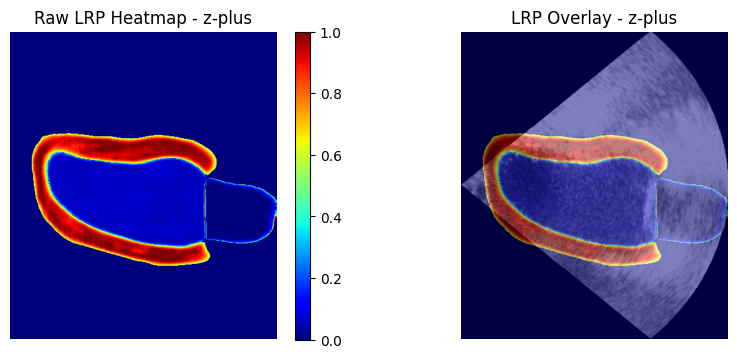


=== LRP Rule: gamma ===
Relevance stats: min = 0.0 max = 295.0220031738281 mean = 0.017240824177861214


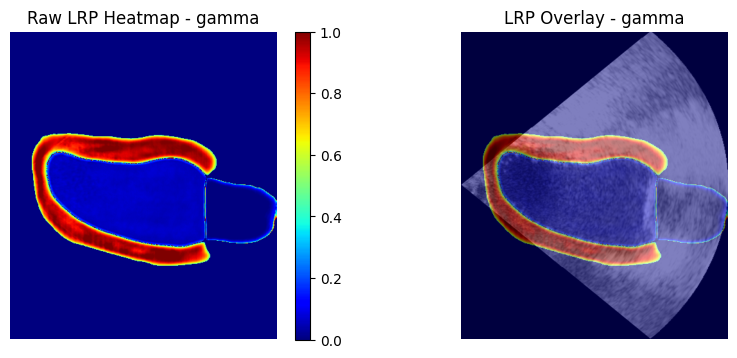


=== LRP Rule: alpha-beta ===
Relevance stats: min = 0.0 max = 23.423503875732422 mean = 0.11414289474487305


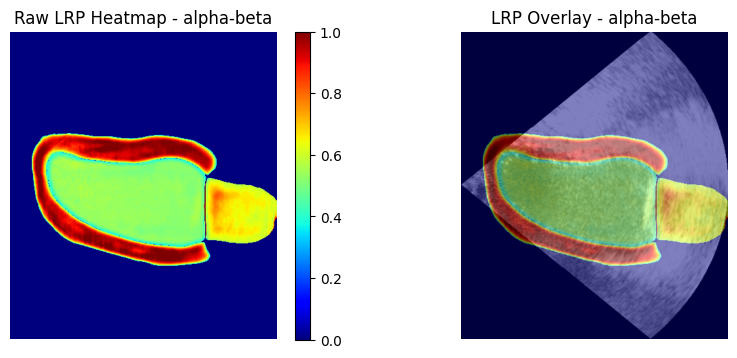


=== LRP Rule: flat ===
Relevance stats: min = -0.20334619283676147 max = 0.0 mean = -0.05863618105649948


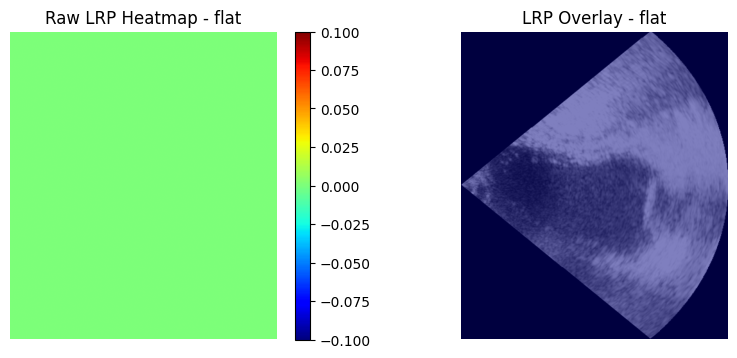


=== LRP Rule: w-squared ===
Relevance stats: min = -0.43858498334884644 max = 0.8391220569610596 mean = 0.06665419042110443


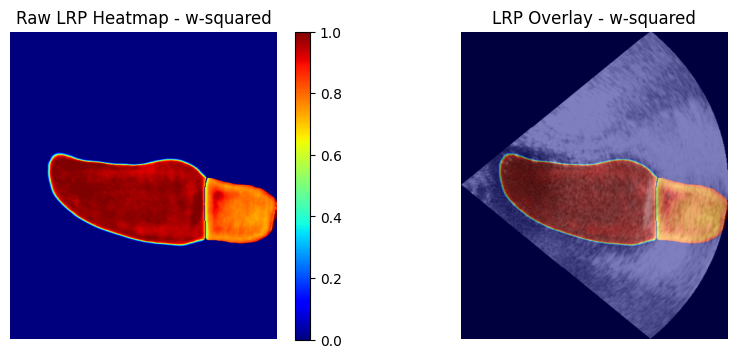


=== LRP Rule: zB ===
Relevance stats: min = -0.974340558052063 max = 0.6923553943634033 mean = -0.06411765515804291


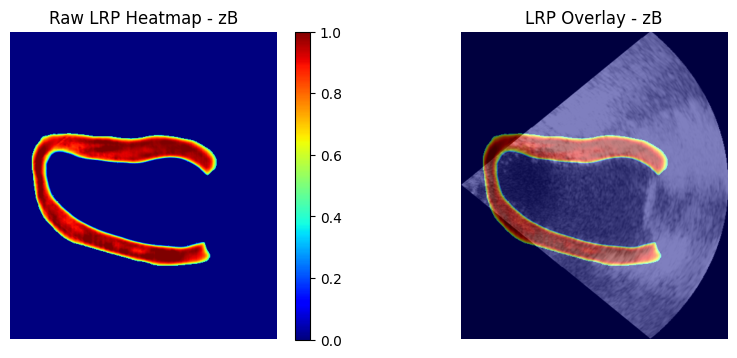

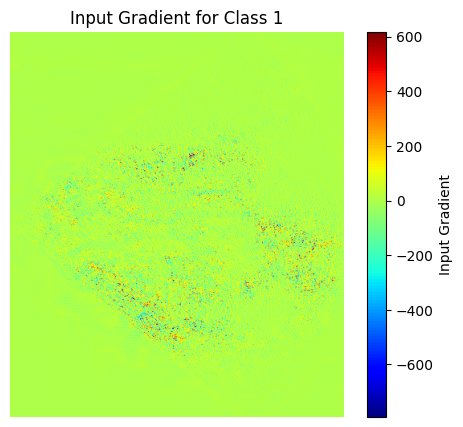

In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt


def main():
    # ----------------------------
    # 1. Setup & Model Loading
    # ----------------------------
    model_path = r"F:\Rohit\LRP\Custom_Unet\cu_unet.pth"
    image_path = r"F:\Rohit\LRP\Custom_Unet\Dataset\img_480_416\patient0001_2CH_ED.png"

    model = nnUNet()
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
    model.eval()

    image = load_image(image_path, target_size=(416, 480))  # [1,3,H,W]
    image.requires_grad_(True)

    # Handle model output safely
    model_output = model(image)
    if isinstance(model_output, (tuple, list)):
        output = model_output[0]
        pre_output = model_output[1] if len(model_output) > 1 else None
    else:
        output = model_output
        pre_output = None

    segmentation_output = torch.sigmoid(output)

    print("Segmentation output stats:",
          "min =", segmentation_output.min().item(),
          "max =", segmentation_output.max().item(),
          "mean =", segmentation_output.mean().item())

    # Convert original image for visualization (shape: [H,W,3])
    orig_img_np = image[0].permute(1, 2, 0).detach().cpu().numpy()
    orig_img_np = np.clip(orig_img_np, 0, 1)

    # ----------------------------
    # 2. Visualize Segmentation Mask Overlay
    # ----------------------------
    seg_mask = (segmentation_output.mean(dim=1, keepdim=True) > 0.3).float()
    seg_mask_np = seg_mask[0, 0].detach().cpu().numpy()
    overlaid_seg = overlay_seg_mask_on_image(orig_img_np, seg_mask_np, alpha=0.3, mask_color=(1, 0, 0))
    plt.figure()
    plt.imshow(overlaid_seg)
    plt.title("Segmentation Mask Overlaid on Original")
    plt.axis("off")
    plt.show()

    # ----------------------------
    # 3. Run Each LRP Rule and Visualize Results
    # ----------------------------
    class_idx = 1  # Choose the output channel (class) to analyze
    for rule_name, lrp_fn in lrp_functions.items():
        print(f"\n=== LRP Rule: {rule_name} ===")
        relevance = output.detach().clone()  # [B, out_channels, H, W]
        relevance = lrp_class_specific(relevance, class_idx)  # [B,1,H,W]

        # Skip if no pre_output available
        if pre_output is None:
            print(f"Skipping {rule_name}: intermediate features not available.")
            continue

        # Apply rule
        if rule_name == "flat":
            relevance = lrp_fn(model.out_conv, pre_output, relevance, seg_mask=seg_mask)
        else:
            relevance = lrp_fn(model.out_conv, pre_output, relevance)

        # If multiple channels, average them
        if relevance.shape[1] > 1:
            relevance = relevance.mean(dim=1, keepdim=True)

        # Apply segmentation mask
        relevance = apply_segmentation_mask(relevance, seg_mask, threshold=0.3)
        print("Relevance stats:",
              "min =", relevance.min().item(),
              "max =", relevance.max().item(),
              "mean =", relevance.mean().item())

        # Normalize heatmap
        heatmap = relevance.detach().squeeze().cpu().numpy()
        p99 = np.percentile(heatmap, 99)
        heatmap = np.clip(heatmap, 0, p99)
        hm_min, hm_max = heatmap.min(), heatmap.max()
        if hm_max > hm_min:
            heatmap = (heatmap - hm_min) / (hm_max - hm_min)
        else:
            heatmap = np.zeros_like(heatmap)

        # Overlay and plot
        overlaid_hm = overlay_heatmap_on_image(orig_img_np, heatmap, alpha=0.5, cmap='jet')

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(heatmap, cmap='jet')
        plt.colorbar()
        plt.title(f"Raw LRP Heatmap - {rule_name}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(overlaid_hm)
        plt.title(f"LRP Overlay - {rule_name}")
        plt.axis("off")
        plt.show()

    # ----------------------------
    # 4. Input Gradient Visualization
    # ----------------------------
    model.zero_grad()
    output[0, class_idx].sum().backward(retain_graph=True)
    grad = image.grad.data[0, 0, :, :].cpu().numpy()
    plt.figure(figsize=(6, 5))
    plt.imshow(grad, cmap='jet')
    plt.colorbar(label="Input Gradient")
    plt.title(f"Input Gradient for Class {class_idx}")
    plt.axis("off")
    plt.show()



if __name__ == "__main__":
    main()


  Sparsity (90th pct):      0.1000 (10.0%)
  Localization IoU (90th):  0.2447 (24.5%)
  Faithfulness (corr):      0.2948 (29.5%)
  Stability (cos sim):      0.8428 (84.3%)


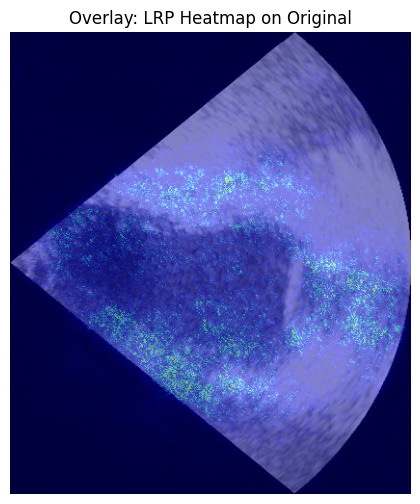

In [54]:
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# ----------------------------------------
# 1) Your nnUNet definition (unchanged)
# Add your ConvBlock, DownBlock, UpBlock, nnUNet here
# ----------------------------------------

# ----------------------------------------
# 2) I/O helpers
# ----------------------------------------
def load_image(path, target_size=(416,480)):
    gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    gray = cv2.resize(gray, target_size)
    gray = gray.astype(np.float32) / 255.0
    img3 = np.stack([gray, gray, gray], axis=0)
    return torch.from_numpy(img3).unsqueeze(0)  # 1×3×H×W

def load_mask_triplet(mask_parent_dir, filename, target_size=(416,480)):
    base, ext = os.path.splitext(filename)
    fname = base + "_gt" + ext
    masks = []
    for j in [1,2,3]:
        p = os.path.join(mask_parent_dir, f"Lobe_{j}", fname)
        m = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        m = cv2.resize(m, target_size)
        masks.append((m > 127).astype(np.uint8))
    combined = np.clip(masks[0] + masks[1] + masks[2], 0, 1)
    return combined  # H×W

# ----------------------------------------
# 3) Explainability metric functions
# ----------------------------------------
def compute_sparsity(heatmap, perc=90):
    thresh = np.percentile(heatmap, perc)
    return np.mean(heatmap >= thresh)

def compute_localization(heatmap, gt_mask, perc=90):
    thresh = np.percentile(heatmap, perc)
    bin_map = (heatmap >= thresh).astype(np.uint8)
    inter = np.logical_and(bin_map, gt_mask).sum()
    union = np.logical_or(bin_map, gt_mask).sum()
    return inter / union if union > 0 else 0.0

def compute_stability(model, image, class_idx, compute_heatmap_fn, noise_std=0.01, device='cpu'):
    orig = compute_heatmap_fn(model, image, class_idx, device=device)
    noise = image + torch.randn_like(image) * noise_std
    pert = compute_heatmap_fn(model, noise, class_idx, device=device)
    o_flat = orig.flatten()[None, :]
    p_flat = pert.flatten()[None, :]
    return cosine_similarity(o_flat, p_flat)[0, 0]

def compute_lrp_heatmap(model, image, class_idx=0, device='cpu'):
    model.to(device)
    image = image.to(device).clone().requires_grad_(True)
    output = model(image)
    if isinstance(output, (tuple, list)):
        out = output[0]
    else:
        out = output

    score = out[0, class_idx].sum()
    model.zero_grad()
    score.backward()
    grad = image.grad[0].detach().abs().mean(dim=0).cpu().numpy()
    mn, mx = grad.min(), grad.max()
    return (grad - mn) / (mx - mn + 1e-8)

# ----------------------------------------
# 4) Main script
# ----------------------------------------
def main():
    model_path      = r"F:\Rohit\LRP\Custom_Unet\cu_unet.pth"
    image_path      = r"F:\Rohit\LRP\Custom_Unet\Dataset\img_480_416\patient0001_2CH_ED.png"
    mask_parent_dir = r"F:\Rohit\LRP\Custom_Unet\Dataset\segmented_output"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model
    model = nnUNet()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Load image + combined mask
    img = load_image(image_path)  # 1×3×H×W
    gt = load_mask_triplet(mask_parent_dir, os.path.basename(image_path))  # H×W

    # Compute LRP heatmap
    heatmap = compute_lrp_heatmap(model, img, class_idx=1, device=device)

    # Get segmentation probability for class 0
    with torch.no_grad():
        model_output = model(img.to(device))
        logits = model_output[0] if isinstance(model_output, (tuple, list)) else model_output
        seg_prob = torch.sigmoid(logits)[0, 0].detach().cpu().numpy()

    # Compute explainability metrics
    sp   = compute_sparsity(heatmap, perc=90)
    loc  = compute_localization(heatmap, gt, perc=90)
    corr = np.corrcoef(heatmap.flatten(), seg_prob.flatten())[0, 1]
    stab = compute_stability(model, img, 0, compute_lrp_heatmap, noise_std=0.01, device=device)

    # Print results with percentages
    print(f"  Sparsity (90th pct):      {sp:.4f} ({sp*100:.1f}%)")
    print(f"  Localization IoU (90th):  {loc:.4f} ({loc*100:.1f}%)")
    print(f"  Faithfulness (corr):      {corr:.4f} ({corr*100:.1f}%)")
    print(f"  Stability (cos sim):      {stab:.4f} ({stab*100:.1f}%)")

    # Optional visualization
    orig = img[0].permute(1, 2, 0).cpu().numpy().clip(0, 1)
    plt.figure(figsize=(6, 6))
    plt.imshow(orig, cmap='gray')
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title("Overlay: LRP Heatmap on Original")
    plt.show()

if __name__ == "__main__":
    main()


Segmentation output stats: min = 2.547896292526275e-05 max = 0.999937891960144 mean = 0.09842473268508911


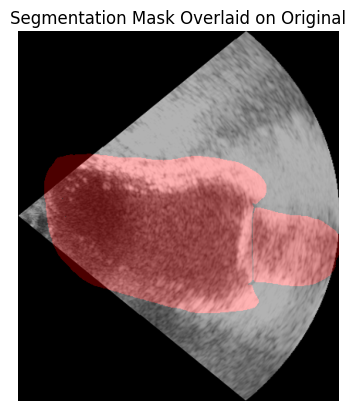


=== LRP Rule: LRP-0 ===
Relevance stats: min = -81.923828125 max = 464.6644287109375 mean = -0.14921998977661133


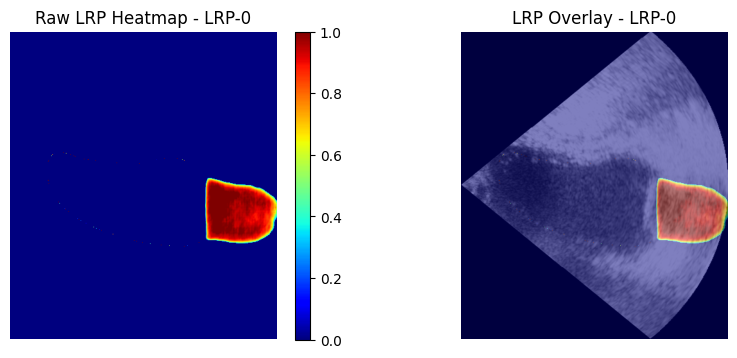


=== LRP Rule: epsilon ===
Relevance stats: min = -81.923828125 max = 461.31396484375 mean = -0.14923691749572754


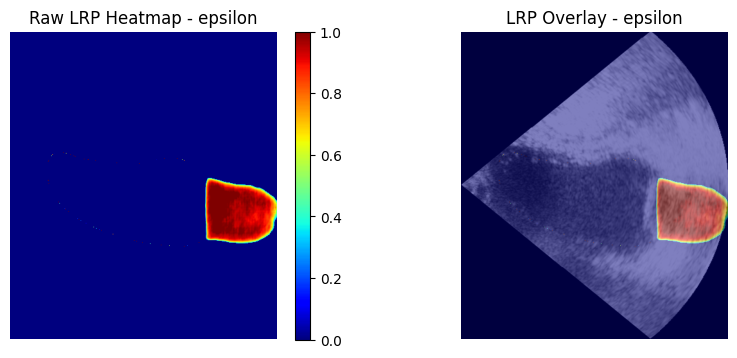


=== LRP Rule: z-plus ===
Relevance stats: min = 0.0 max = 638.0203857421875 mean = 0.027864009141921997


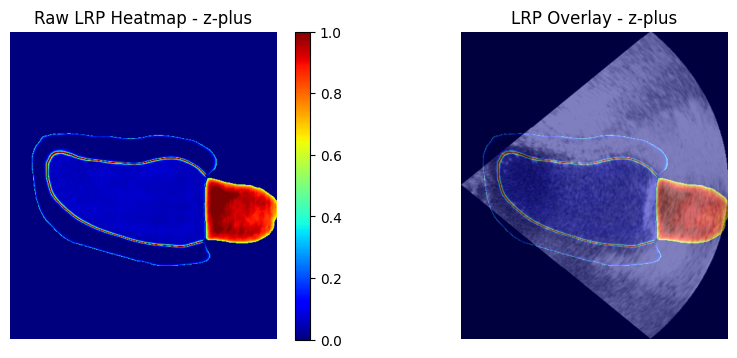


=== LRP Rule: gamma ===
Relevance stats: min = 0.0 max = 1638.3603515625 mean = 0.02583220973610878


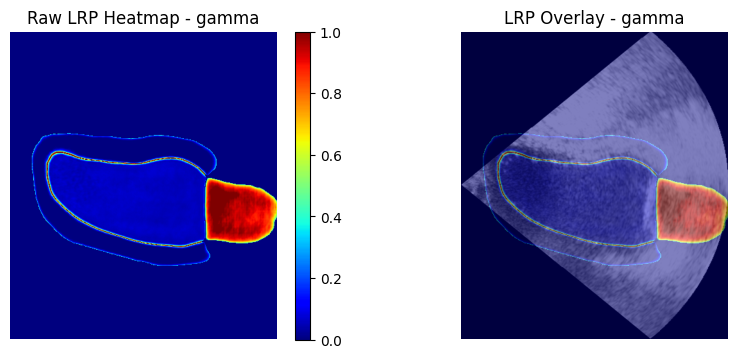


=== LRP Rule: alpha-beta ===
Relevance stats: min = 0.0 max = 3267.55322265625 mean = 0.17079266905784607


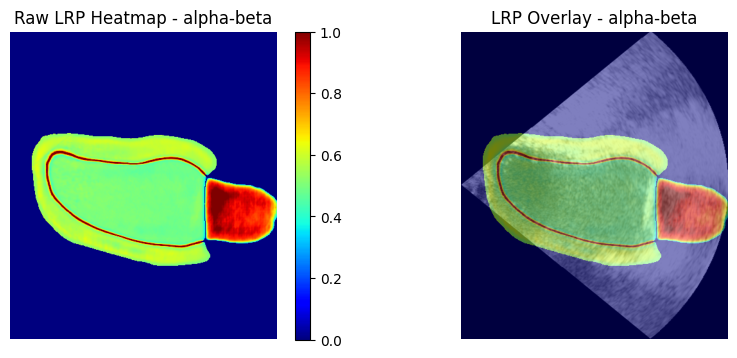


=== LRP Rule: flat ===
Relevance stats: min = -0.240855872631073 max = 0.0 mean = -0.06945233792066574


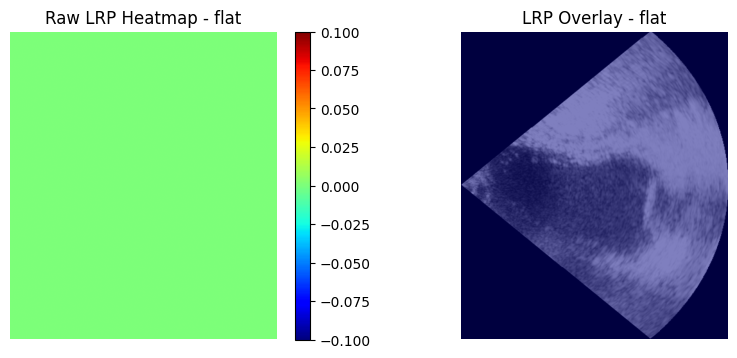


=== LRP Rule: w-squared ===
Relevance stats: min = -0.5265234708786011 max = 0.7286323308944702 mean = 0.11828187853097916


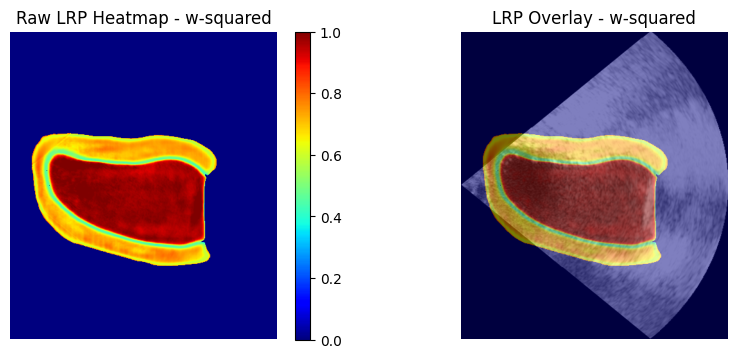


=== LRP Rule: zB ===
Relevance stats: min = -26.67013168334961 max = 67.05538940429688 mean = -0.15020616352558136


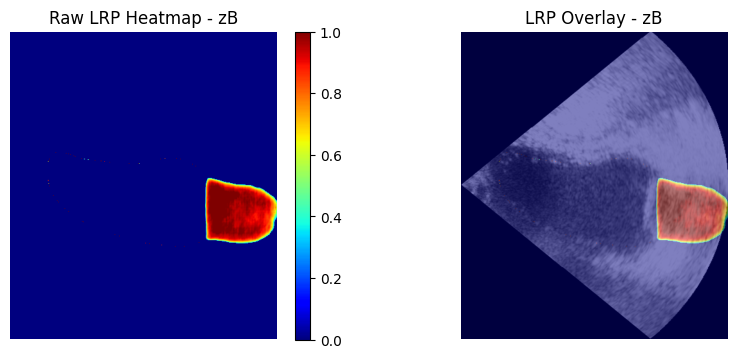

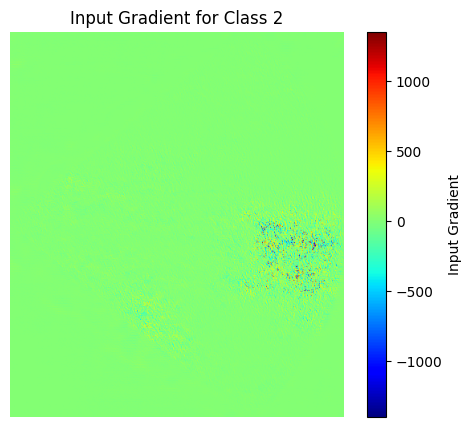

In [56]:
import torch
import numpy as np
import matplotlib.pyplot as plt


def main():
    # ----------------------------
    # 1. Setup & Model Loading
    # ----------------------------
    model_path = r"F:\Rohit\LRP\Custom_Unet\cu_unet.pth"
    image_path = r"F:\Rohit\LRP\Custom_Unet\Dataset\img_480_416\patient0001_2CH_ED.png"

    model = nnUNet()
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
    model.eval()

    image = load_image(image_path, target_size=(416, 480))  # [1,3,H,W]
    image.requires_grad_(True)

    # Handle model output safely
    model_output = model(image)
    if isinstance(model_output, (tuple, list)):
        output = model_output[0]
        pre_output = model_output[1] if len(model_output) > 1 else None
    else:
        output = model_output
        pre_output = None

    segmentation_output = torch.sigmoid(output)

    print("Segmentation output stats:",
          "min =", segmentation_output.min().item(),
          "max =", segmentation_output.max().item(),
          "mean =", segmentation_output.mean().item())

    # Convert original image for visualization (shape: [H,W,3])
    orig_img_np = image[0].permute(1, 2, 0).detach().cpu().numpy()
    orig_img_np = np.clip(orig_img_np, 0, 1)

    # ----------------------------
    # 2. Visualize Segmentation Mask Overlay
    # ----------------------------
    seg_mask = (segmentation_output.mean(dim=1, keepdim=True) > 0.3).float()
    seg_mask_np = seg_mask[0, 0].detach().cpu().numpy()
    overlaid_seg = overlay_seg_mask_on_image(orig_img_np, seg_mask_np, alpha=0.3, mask_color=(1, 0, 0))
    plt.figure()
    plt.imshow(overlaid_seg)
    plt.title("Segmentation Mask Overlaid on Original")
    plt.axis("off")
    plt.show()

    # ----------------------------
    # 3. Run Each LRP Rule and Visualize Results
    # ----------------------------
    class_idx = 2  # Choose the output channel (class) to analyze
    for rule_name, lrp_fn in lrp_functions.items():
        print(f"\n=== LRP Rule: {rule_name} ===")
        relevance = output.detach().clone()  # [B, out_channels, H, W]
        relevance = lrp_class_specific(relevance, class_idx)  # [B,1,H,W]

        # Skip if no pre_output available
        if pre_output is None:
            print(f"Skipping {rule_name}: intermediate features not available.")
            continue

        # Apply rule
        if rule_name == "flat":
            relevance = lrp_fn(model.out_conv, pre_output, relevance, seg_mask=seg_mask)
        else:
            relevance = lrp_fn(model.out_conv, pre_output, relevance)

        # If multiple channels, average them
        if relevance.shape[1] > 1:
            relevance = relevance.mean(dim=1, keepdim=True)

        # Apply segmentation mask
        relevance = apply_segmentation_mask(relevance, seg_mask, threshold=0.3)
        print("Relevance stats:",
              "min =", relevance.min().item(),
              "max =", relevance.max().item(),
              "mean =", relevance.mean().item())

        # Normalize heatmap
        heatmap = relevance.detach().squeeze().cpu().numpy()
        p99 = np.percentile(heatmap, 99)
        heatmap = np.clip(heatmap, 0, p99)
        hm_min, hm_max = heatmap.min(), heatmap.max()
        if hm_max > hm_min:
            heatmap = (heatmap - hm_min) / (hm_max - hm_min)
        else:
            heatmap = np.zeros_like(heatmap)

        # Overlay and plot
        overlaid_hm = overlay_heatmap_on_image(orig_img_np, heatmap, alpha=0.5, cmap='jet')

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(heatmap, cmap='jet')
        plt.colorbar()
        plt.title(f"Raw LRP Heatmap - {rule_name}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(overlaid_hm)
        plt.title(f"LRP Overlay - {rule_name}")
        plt.axis("off")
        plt.show()

    # ----------------------------
    # 4. Input Gradient Visualization
    # ----------------------------
    model.zero_grad()
    output[0, class_idx].sum().backward(retain_graph=True)
    grad = image.grad.data[0, 0, :, :].cpu().numpy()
    plt.figure(figsize=(6, 5))
    plt.imshow(grad, cmap='jet')
    plt.colorbar(label="Input Gradient")
    plt.title(f"Input Gradient for Class {class_idx}")
    plt.axis("off")
    plt.show()



if __name__ == "__main__":
    main()


  Sparsity (90th pct):      0.1000 (10.0%)
  Localization IoU (90th):  0.2200 (22.0%)
  Faithfulness (corr):      0.0556 (5.6%)
  Stability (cos sim):      0.8478 (84.8%)


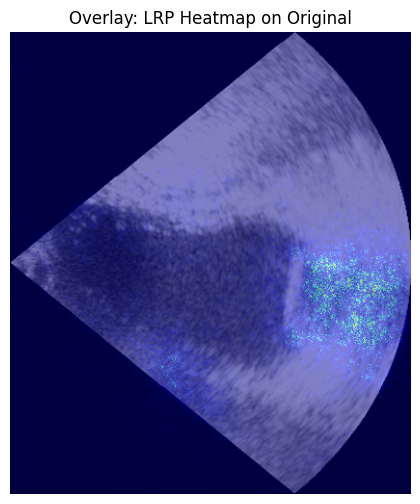

In [57]:
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# ----------------------------------------
# 1) Your nnUNet definition (unchanged)
# Add your ConvBlock, DownBlock, UpBlock, nnUNet here
# ----------------------------------------

# ----------------------------------------
# 2) I/O helpers
# ----------------------------------------
def load_image(path, target_size=(416,480)):
    gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    gray = cv2.resize(gray, target_size)
    gray = gray.astype(np.float32) / 255.0
    img3 = np.stack([gray, gray, gray], axis=0)
    return torch.from_numpy(img3).unsqueeze(0)  # 1×3×H×W

def load_mask_triplet(mask_parent_dir, filename, target_size=(416,480)):
    base, ext = os.path.splitext(filename)
    fname = base + "_gt" + ext
    masks = []
    for j in [1,2,3]:
        p = os.path.join(mask_parent_dir, f"Lobe_{j}", fname)
        m = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        m = cv2.resize(m, target_size)
        masks.append((m > 127).astype(np.uint8))
    combined = np.clip(masks[0] + masks[1] + masks[2], 0, 1)
    return combined  # H×W

# ----------------------------------------
# 3) Explainability metric functions
# ----------------------------------------
def compute_sparsity(heatmap, perc=90):
    thresh = np.percentile(heatmap, perc)
    return np.mean(heatmap >= thresh)

def compute_localization(heatmap, gt_mask, perc=90):
    thresh = np.percentile(heatmap, perc)
    bin_map = (heatmap >= thresh).astype(np.uint8)
    inter = np.logical_and(bin_map, gt_mask).sum()
    union = np.logical_or(bin_map, gt_mask).sum()
    return inter / union if union > 0 else 0.0

def compute_stability(model, image, class_idx, compute_heatmap_fn, noise_std=0.01, device='cpu'):
    orig = compute_heatmap_fn(model, image, class_idx, device=device)
    noise = image + torch.randn_like(image) * noise_std
    pert = compute_heatmap_fn(model, noise, class_idx, device=device)
    o_flat = orig.flatten()[None, :]
    p_flat = pert.flatten()[None, :]
    return cosine_similarity(o_flat, p_flat)[0, 0]

def compute_lrp_heatmap(model, image, class_idx=2, device='cpu'):
    model.to(device)
    image = image.to(device).clone().requires_grad_(True)
    output = model(image)
    if isinstance(output, (tuple, list)):
        out = output[0]
    else:
        out = output

    score = out[0, class_idx].sum()
    model.zero_grad()
    score.backward()
    grad = image.grad[0].detach().abs().mean(dim=0).cpu().numpy()
    mn, mx = grad.min(), grad.max()
    return (grad - mn) / (mx - mn + 1e-8)

# ----------------------------------------
# 4) Main script
# ----------------------------------------
def main():
    model_path      = r"F:\Rohit\LRP\Custom_Unet\cu_unet.pth"
    image_path      = r"F:\Rohit\LRP\Custom_Unet\Dataset\img_480_416\patient0001_2CH_ED.png"
    mask_parent_dir = r"F:\Rohit\LRP\Custom_Unet\Dataset\segmented_output"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model
    model = nnUNet()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Load image + combined mask
    img = load_image(image_path)  # 1×3×H×W
    gt = load_mask_triplet(mask_parent_dir, os.path.basename(image_path))  # H×W

    # Compute LRP heatmap
    heatmap = compute_lrp_heatmap(model, img, class_idx=2, device=device)

    # Get segmentation probability for class 0
    with torch.no_grad():
        model_output = model(img.to(device))
        logits = model_output[0] if isinstance(model_output, (tuple, list)) else model_output
        seg_prob = torch.sigmoid(logits)[0, 0].detach().cpu().numpy()

    # Compute explainability metrics
    sp   = compute_sparsity(heatmap, perc=90)
    loc  = compute_localization(heatmap, gt, perc=90)
    corr = np.corrcoef(heatmap.flatten(), seg_prob.flatten())[0, 1]
    stab = compute_stability(model, img, 0, compute_lrp_heatmap, noise_std=0.01, device=device)

    # Print results with percentages
    print(f"  Sparsity (90th pct):      {sp:.4f} ({sp*100:.1f}%)")
    print(f"  Localization IoU (90th):  {loc:.4f} ({loc*100:.1f}%)")
    print(f"  Faithfulness (corr):      {corr:.4f} ({corr*100:.1f}%)")
    print(f"  Stability (cos sim):      {stab:.4f} ({stab*100:.1f}%)")

    # Optional visualization
    orig = img[0].permute(1, 2, 0).cpu().numpy().clip(0, 1)
    plt.figure(figsize=(6, 6))
    plt.imshow(orig, cmap='gray')
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title("Overlay: LRP Heatmap on Original")
    plt.show()

if __name__ == "__main__":
    main()


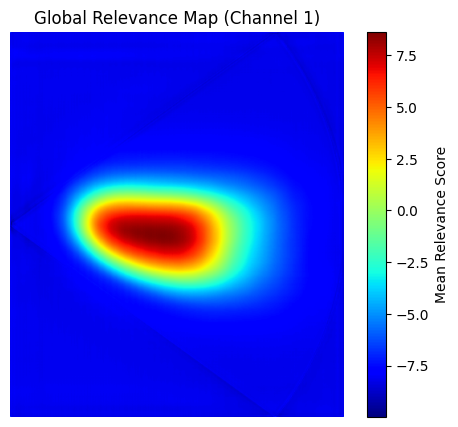

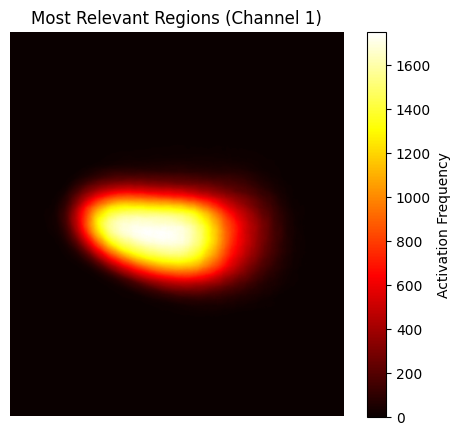

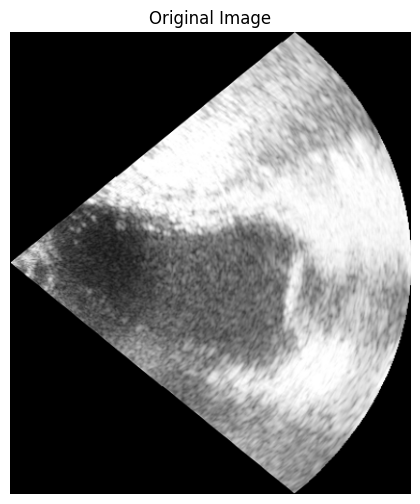

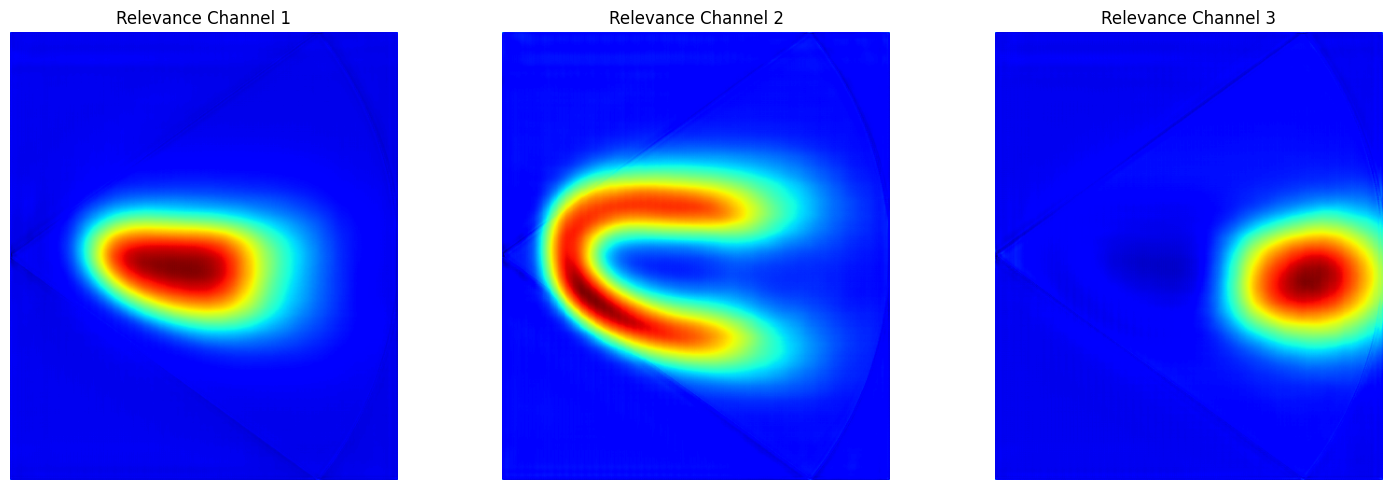

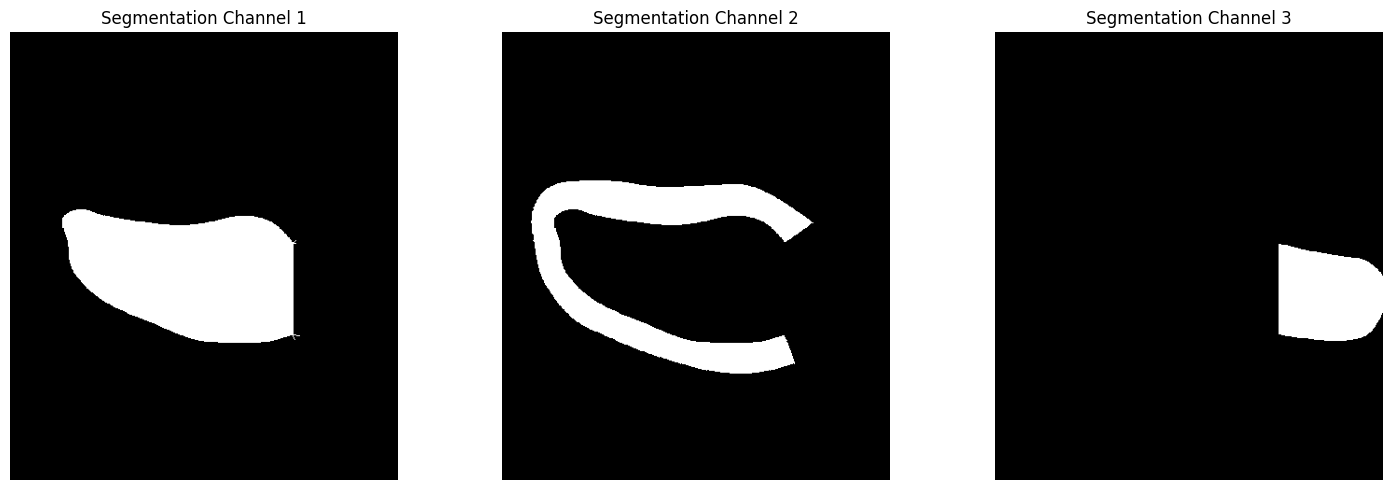

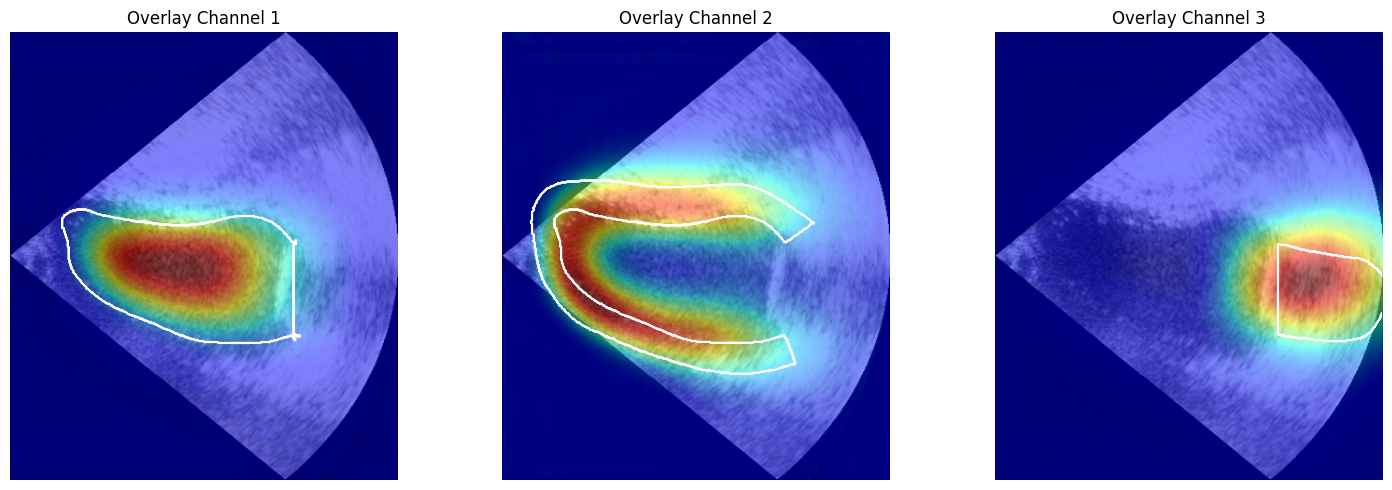

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

############################################
# 1. Custom Dataset for images and masks   #
############################################

class SegmentationDataset(Dataset):
    def __init__(self, img_dir, seg_dir, transform=None, seg_transform=None):
        """
        Args:
            img_dir (str): Path to the folder with images.
            seg_dir (str): Path to the folder containing subfolders for segmentation masks.
                           Each subfolder (e.g., Lobe_1, Lobe_2, Lobe_3) contains segmentation masks.
            transform (callable, optional): Transform to be applied on an image.
            seg_transform (callable, optional): Transform to be applied on a segmentation mask.
        """
        self.img_dir = img_dir
        self.img_files = sorted(os.listdir(img_dir))
        # List subdirectories in seg_dir (e.g., Lobe_1, Lobe_2, Lobe_3)
        self.seg_subdirs = sorted([
            os.path.join(seg_dir, d)
            for d in os.listdir(seg_dir)
            if os.path.isdir(os.path.join(seg_dir, d))
        ])
        self.transform = transform
        self.seg_transform = seg_transform

    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        # Load the image
        img_filename = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_filename)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Create the corresponding segmentation filename.
        # For example: "patient0001_2CH_ED.png" -> "patient0001_2CH_ED_gt.png"
        base, ext = os.path.splitext(img_filename)
        seg_filename = base + "_gt" + ext
        
        # Load the segmentation masks from each subfolder and stack them along the channel dimension.
        seg_masks = []
        for subdir in self.seg_subdirs:
            seg_path = os.path.join(subdir, seg_filename)
            seg = Image.open(seg_path).convert('L')  # Grayscale mask
            if self.seg_transform:
                seg = self.seg_transform(seg)
            # After transform, seg is expected to have shape (1, H, W)
            seg_masks.append(seg)
        # Concatenate the masks to form a multi-channel segmentation tensor.
        segmentation = torch.cat(seg_masks, dim=0)
        return image, segmentation

############################################
# 2. Model Definition (nnUNet)             #
############################################

# Basic convolution block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.01, inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

# Down-sampling block
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )
    def forward(self, x):
        return self.block(x)

# Up-sampling block
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
        self.conv = ConvBlock(out_channels * 2, out_channels)
    def forward(self, x, skip):
        x = self.up(x)
        # Resize if needed
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

# nnUNet model definition
class nnUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_filters=32):
        super().__init__()
        self.in_conv = ConvBlock(in_channels, base_filters)
        self.down1 = DownBlock(base_filters, base_filters * 2)
        self.down2 = DownBlock(base_filters * 2, base_filters * 4)
        self.down3 = DownBlock(base_filters * 4, base_filters * 8)
        self.down4 = DownBlock(base_filters * 8, base_filters * 16)
        self.up1 = UpBlock(base_filters * 16, base_filters * 8)
        self.up2 = UpBlock(base_filters * 8, base_filters * 4)
        self.up3 = UpBlock(base_filters * 4, base_filters * 2)
        self.up4 = UpBlock(base_filters * 2, base_filters)
        self.out_conv = nn.Conv2d(base_filters, out_channels, kernel_size=1)
    def forward(self, x):
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x_up1 = self.up1(x5, x4)
        x_up2 = self.up2(x_up1, x3)
        x_up3 = self.up3(x_up2, x2)
        x_up4 = self.up4(x_up3, x1)
        pre_output = x_up4
        output = self.out_conv(pre_output)
        return output, pre_output
    def relprop(self, relevance, alpha=1):
        """
        Dummy relprop implementation.
        In practice, implement layer-wise relevance propagation here.
        """
        return relevance

############################################
# 3. LRP and Processing Functions          #
############################################

def compute_lrp(output, class_idx, model):
    """Applies LRP for the given model output and class index."""
    relevance = output.clone()
    # Set relevance only for the target class (simplified approach)
    relevance[:, class_idx] = output[:, class_idx]
    relevance = model.relprop(relevance, alpha=1)  # Apply LRP
    return relevance

def process_dataset(dataset, model, device):
    """Processes images from the dataset to generate relevance maps."""
    relevance_maps = []
    # Disable gradient computations during inference.
    with torch.no_grad():
        for img, _ in dataset:  # segmentation masks are not used for forward pass
            img = img.to(device).unsqueeze(0)  # add batch dimension
            output, _ = model(img)  # forward pass; output shape: (1, out_channels, H, W)
            # For segmentation, choose the class with highest activation.
            class_idx = torch.argmax(output, dim=1).view(-1)[0].item()  
            relevance = compute_lrp(output, class_idx, model)
            # Detach before converting to NumPy.
            relevance_maps.append(relevance.detach().cpu().numpy())
    return np.array(relevance_maps)

def aggregate_relevance(relevance_maps):
    """Computes the mean relevance map across the dataset and visualizes it."""
    mean_relevance = np.mean(relevance_maps, axis=0)  # shape: (1, channels, H, W)
    # If more than one channel, select channel 0 for display.
    if mean_relevance.shape[1] == 1:
        mean_relevance_img = mean_relevance[0, 0]
    else:
        mean_relevance_img = mean_relevance[0, 0]  # select channel 0
    plt.figure(figsize=(6, 5))
    plt.imshow(mean_relevance_img, cmap="jet")
    plt.colorbar(label="Mean Relevance Score")
    plt.title("Global Relevance Map (Channel 1)")
    plt.axis('off')
    plt.show()
    return mean_relevance

def highlight_high_relevance(relevance_maps):
    """Visualizes regions that are most frequently activated."""
    threshold = np.percentile(relevance_maps, 95)  # Top 5% relevance
    high_relevance = relevance_maps > threshold         # Binary mask
    frequency_map = np.sum(high_relevance, axis=0)        # Count occurrences; shape: (1, channels, H, W)
    if frequency_map.shape[1] == 1:
        freq_img = frequency_map[0, 0]
    else:
        freq_img = frequency_map[0, 0]  # select channel 0
    plt.figure(figsize=(6, 5))
    plt.imshow(freq_img, cmap="hot")
    plt.colorbar(label="Activation Frequency")
    plt.title("Most Relevant Regions (Channel 1)")
    plt.axis('off')
    plt.show()

def overlay_lrp_on_segmentation(image, relevance_map, segmentation_mask):
    """Overlays LRP relevance on the ground truth segmentation mask and prints all three channels separately."""
    # Convert image to a NumPy array with shape (H, W, C)
    if torch.is_tensor(image):
        image_np = image.permute(1, 2, 0).detach().cpu().numpy()
    else:
        image_np = image

    # Process the relevance map.
    # If relevance_map has shape (1, channels, H, W), remove the batch dimension.
    if relevance_map.ndim == 4:
        if isinstance(relevance_map, torch.Tensor):
            rel_np = relevance_map[0].detach().cpu().numpy()  # shape: (channels, H, W)
        else:
            rel_np = relevance_map[0]
    else:
        rel_np = relevance_map

    # Process the segmentation mask.
    if torch.is_tensor(segmentation_mask):
        seg_np = segmentation_mask.detach().cpu().numpy()  # expected shape: (channels, H, W)
    else:
        seg_np = segmentation_mask

    # If segmentation mask has multiple channels, select the first channel for contouring.
    if seg_np.ndim == 3 and seg_np.shape[0] > 1:
        seg_disp = seg_np[0]
    else:
        seg_disp = np.squeeze(seg_np)

    # -------------------------------
    # 1. Show the original image.
    plt.figure(figsize=(6, 6))
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis("off")
    plt.show()

    # -------------------------------
    # 2. Display each channel of the relevance map.
    if rel_np.ndim == 3:
        channels = rel_np.shape[0]
        fig, axs = plt.subplots(1, channels, figsize=(5 * channels, 5))
        for i in range(channels):
            axs[i].imshow(rel_np[i], cmap='jet')
            axs[i].set_title(f"Relevance Channel {i+1}")
            axs[i].axis("off")
        plt.tight_layout()
        plt.show()

    # -------------------------------
    # 3. Display each channel of the segmentation mask.
    if seg_np.ndim == 2:
        plt.figure(figsize=(6, 6))
        plt.imshow(seg_np, cmap='gray')
        plt.title("Segmentation Mask (Single Channel)")
        plt.axis("off")
        plt.show()
    elif seg_np.ndim == 3:
        channels = seg_np.shape[0]
        fig, axs = plt.subplots(1, channels, figsize=(5 * channels, 5))
        for i in range(channels):
            axs[i].imshow(seg_np[i], cmap='gray')
            axs[i].set_title(f"Segmentation Channel {i+1}")
            axs[i].axis("off")
        plt.tight_layout()
        plt.show()

    # -------------------------------
    # 4. For each channel, overlay the relevance map on the segmentation mask.
    # If segmentation mask is 2D, use it for all overlays.
    if rel_np.ndim == 3 and (seg_np.ndim == 2):
        channels = rel_np.shape[0]
        fig, axs = plt.subplots(1, channels, figsize=(5 * channels, 5))
        for i in range(channels):
            axs[i].imshow(image_np)
            axs[i].imshow(rel_np[i], cmap='jet', alpha=0.5)
            axs[i].contour(seg_np, colors="white", linewidths=1)
            axs[i].set_title(f"Overlay Channel {i+1}")
            axs[i].axis("off")
        plt.tight_layout()
        plt.show()
    elif rel_np.ndim == 3 and seg_np.ndim == 3 and rel_np.shape[0] == seg_np.shape[0]:
        channels = rel_np.shape[0]
        fig, axs = plt.subplots(1, channels, figsize=(5 * channels, 5))
        for i in range(channels):
            axs[i].imshow(image_np)
            axs[i].imshow(rel_np[i], cmap='jet', alpha=0.5)
            axs[i].contour(seg_np[i], colors="white", linewidths=1)
            axs[i].set_title(f"Overlay Channel {i+1}")
            axs[i].axis("off")
        plt.tight_layout()
        plt.show()

############################################
# 4. Example Usage                         #
############################################

if __name__ == "__main__":
    # Paths to the image folder, segmentation folder (with subfolders), and the trained model weights.
    img_dir = r"F:\Rohit\LRP\Custom_Unet\Dataset\img_480_416"
    seg_dir = r"F:\Rohit\LRP\Custom_Unet\Dataset\segmented_output"  # Contains subfolders: Lobe_1, Lobe_2, Lobe_3
    model_path = r"F:\Rohit\LRP\Custom_Unet\cu_unet.pth"

    # Define basic transforms (modify as needed)
    transform = transforms.ToTensor()
    seg_transform = transforms.ToTensor()

    # Create the dataset
    dataset = SegmentationDataset(img_dir, seg_dir, transform=transform, seg_transform=seg_transform)

    # Load the model and weights
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = nnUNet()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Compute relevance maps for the dataset
    relevance_maps = process_dataset(dataset, model, device)

    # Aggregate and visualize the global relevance map and highlight high-relevance regions
    mean_relevance = aggregate_relevance(relevance_maps)
    highlight_high_relevance(relevance_maps)

    # Overlay the LRP result on an example image and its ground truth segmentation mask.
    image, segmentation_mask = dataset[0]  # Get first sample
    overlay_lrp_on_segmentation(image, mean_relevance, segmentation_mask)



In [73]:
# ===========================
# 5. Global Explainability Evaluation
# ===========================
from sklearn.metrics.pairwise import cosine_similarity

def compute_sparsity(heatmap, perc=90):
    thresh = np.percentile(heatmap, perc)
    return np.mean(heatmap >= thresh)

def compute_localization(heatmap, gt_mask, perc=90):
    thresh = np.percentile(heatmap, perc)
    bin_map = (heatmap >= thresh).astype(np.uint8)
    inter = np.logical_and(bin_map, gt_mask).sum()
    union = np.logical_or(bin_map, gt_mask).sum()
    return inter / union if union > 0 else 0.0

def compute_faithfulness(heatmap, model_output, class_idx=0):
    seg_prob = torch.sigmoid(model_output)[0, class_idx].detach().cpu().numpy()
    return np.corrcoef(heatmap.flatten(), seg_prob.flatten())[0, 1]

def compute_stability(model, image, class_idx, compute_heatmap_fn, noise_std=0.01, device='cpu'):
    orig = compute_heatmap_fn(model, image, class_idx, device=device)
    noise = image + torch.randn_like(image) * noise_std
    pert = compute_heatmap_fn(model, noise, class_idx, device=device)
    o_flat = orig.flatten()[None, :]
    p_flat = pert.flatten()[None, :]
    return cosine_similarity(o_flat, p_flat)[0, 0]

def compute_lrp_heatmap(model, image, class_idx=0, device='cpu'):
    model.to(device)
    image = image.to(device).clone().requires_grad_(True)
    output, _ = model(image)
    score = output[0, class_idx].sum()
    model.zero_grad()
    score.backward()
    grad = image.grad[0].abs().mean(dim=0).cpu().numpy()
    mn, mx = grad.min(), grad.max()
    return (grad - mn) / (mx - mn + 1e-8), output

def evaluate_global_explainability_metrics(dataset, model, device, class_idx=0):
    print("\n--- Global LRP Metrics Evaluation ---")
    sparsity_list = []
    localization_list = []
    faithfulness_list = []
    stability_list = []

    for img, seg_mask in dataset:
        img = img.to(device).unsqueeze(0)  # add batch dimension
        seg_mask_np = seg_mask[0].numpy()  # pick first lobe mask for simplicity

        heatmap, output = compute_lrp_heatmap(model, img, class_idx, device=device)

        sparsity_list.append(compute_sparsity(heatmap))
        localization_list.append(compute_localization(heatmap, seg_mask_np))
        faithfulness_list.append(compute_faithfulness(heatmap, output, class_idx))
        stability_list.append(compute_stability(model, img, class_idx, compute_lrp_heatmap, device=device))

    print(f"Sparsity (90th pct)     : {np.mean(sparsity_list):.4f} ± {np.std(sparsity_list):.4f} ({np.mean(sparsity_list)*100:.1f}%)")
    print(f"Localization IoU (90th) : {np.mean(localization_list):.4f} ± {np.std(localization_list):.4f} ({np.mean(localization_list)*100:.1f}%)")
    print(f"Faithfulness (corr)     : {np.mean(faithfulness_list):.4f} ± {np.std(faithfulness_list):.4f} ({np.mean(faithfulness_list)*100:.1f}%)")
    print(f"Stability (cos sim)     : {np.mean(stability_list):.4f} ± {np.std(stability_list):.4f} ({np.mean(stability_list)*100:.1f}%)")


In [77]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity

############################################
# 1. Custom Dataset for images and masks   #
############################################

class SegmentationDataset(Dataset):
    def __init__(self, img_dir, seg_dir, transform=None, seg_transform=None):
        self.img_dir = img_dir
        self.img_files = sorted(os.listdir(img_dir))
        self.seg_subdirs = sorted([
            os.path.join(seg_dir, d)
            for d in os.listdir(seg_dir)
            if os.path.isdir(os.path.join(seg_dir, d))
        ])
        self.transform = transform
        self.seg_transform = seg_transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_filename = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_filename)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        base, ext = os.path.splitext(img_filename)
        seg_filename = base + "_gt" + ext

        seg_masks = []
        for subdir in self.seg_subdirs:
            seg_path = os.path.join(subdir, seg_filename)
            seg = Image.open(seg_path).convert('L')
            if self.seg_transform:
                seg = self.seg_transform(seg)
            seg_masks.append(seg)
        segmentation = torch.cat(seg_masks, dim=0)
        return image, segmentation

############################################
# 2. Model Definition (nnUNet)             #
############################################

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.01, inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )
    def forward(self, x):
        return self.block(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
        self.conv = ConvBlock(out_channels * 2, out_channels)
    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class nnUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_filters=32):
        super().__init__()
        self.in_conv = ConvBlock(in_channels, base_filters)
        self.down1 = DownBlock(base_filters, base_filters * 2)
        self.down2 = DownBlock(base_filters * 2, base_filters * 4)
        self.down3 = DownBlock(base_filters * 4, base_filters * 8)
        self.down4 = DownBlock(base_filters * 8, base_filters * 16)
        self.up1 = UpBlock(base_filters * 16, base_filters * 8)
        self.up2 = UpBlock(base_filters * 8, base_filters * 4)
        self.up3 = UpBlock(base_filters * 4, base_filters * 2)
        self.up4 = UpBlock(base_filters * 2, base_filters)
        self.out_conv = nn.Conv2d(base_filters, out_channels, kernel_size=1)
    def forward(self, x):
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x_up1 = self.up1(x5, x4)
        x_up2 = self.up2(x_up1, x3)
        x_up3 = self.up3(x_up2, x2)
        x_up4 = self.up4(x_up3, x1)
        pre_output = x_up4
        output = self.out_conv(pre_output)
        return output, pre_output
    def relprop(self, relevance, alpha=1):
        return relevance

############################################
# 3. Global Evaluation Function            #
############################################

def compute_lrp_heatmap(model, image, class_idx, device):
    model.eval()
    image = image.to(device).clone().requires_grad_(True)
    output, _ = model(image)
    score = output[0, class_idx].sum()
    model.zero_grad()
    score.backward()
    grad = image.grad[0].abs().mean(dim=0).cpu().numpy()
    mn, mx = grad.min(), grad.max()
    return (grad - mn) / (mx - mn + 1e-8), output.detach()

def compute_sparsity(heatmap, perc=90):
    return np.mean(heatmap >= np.percentile(heatmap, perc))

def compute_localization(heatmap, seg_mask, perc=90):
    bin_map = (heatmap >= np.percentile(heatmap, perc)).astype(np.uint8)
    seg_mask = seg_mask.squeeze().numpy() if torch.is_tensor(seg_mask) else seg_mask
    intersection = np.logical_and(bin_map, seg_mask).sum()
    union = np.logical_or(bin_map, seg_mask).sum()
    return intersection / union if union > 0 else 0.0

def compute_faithfulness(heatmap, output, class_idx):
    output_np = torch.sigmoid(output)[0, class_idx].detach().cpu().numpy()
    return np.corrcoef(heatmap.flatten(), output_np.flatten())[0,1]

def compute_stability(model, image, class_idx, heatmap_fn, device):
    orig, _ = heatmap_fn(model, image, class_idx, device)
    noise = image + torch.randn_like(image) * 0.01
    pert, _ = heatmap_fn(model, noise, class_idx, device)
    return cosine_similarity(orig.flatten()[None, :], pert.flatten()[None, :])[0, 0]

def evaluate_global_explainability_metrics(dataset, model, device):
    sparsity_list = [[], [], []]
    localization_list = [[], [], []]
    faithfulness_list = [[], [], []]
    stability_list = [[], [], []]

    for img, seg in dataset:
        img = img.unsqueeze(0).to(device)
        for class_idx in range(3):
            heatmap, output = compute_lrp_heatmap(model, img, class_idx, device)
            sparsity_list[class_idx].append(compute_sparsity(heatmap))
            localization_list[class_idx].append(compute_localization(heatmap, seg[class_idx]))
            faithfulness_list[class_idx].append(compute_faithfulness(heatmap, output, class_idx))
            stability_list[class_idx].append(compute_stability(model, img, class_idx, compute_lrp_heatmap, device))

    for i in range(3):
        print(f"\nClass {i} Metrics:")
        print(f"  Sparsity (90th pct)     : {np.mean(sparsity_list[i]):.4f} ± {np.std(sparsity_list[i]):.4f} ({np.mean(sparsity_list[i])*100:.1f}%)")
        print(f"  Localization IoU (90th) : {np.mean(localization_list[i]):.4f} ± {np.std(localization_list[i]):.4f} ({np.mean(localization_list[i])*100:.1f}%)")
        print(f"  Faithfulness (corr)     : {np.mean(faithfulness_list[i]):.4f} ± {np.std(faithfulness_list[i]):.4f} ({np.mean(faithfulness_list[i])*100:.1f}%)")
        print(f"  Stability (cos sim)     : {np.mean(stability_list[i]):.4f} ± {np.std(stability_list[i]):.4f} ({np.mean(stability_list[i])*100:.1f}%)")

############################################
# 4. Run Evaluation                        #
############################################

if __name__ == "__main__":
    img_dir = r"F:\\Rohit\\LRP\\Custom_Unet\\Dataset\\img_480_416"
    seg_dir = r"F:\\Rohit\\LRP\\Custom_Unet\\Dataset\\segmented_output"
    model_path = r"F:\\Rohit\\LRP\\Custom_Unet\\cu_unet.pth"

    transform = transforms.ToTensor()
    seg_transform = transforms.ToTensor()
    dataset = SegmentationDataset(img_dir, seg_dir, transform=transform, seg_transform=seg_transform)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = nnUNet()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    evaluate_global_explainability_metrics(dataset, model, device)



Class 0 Metrics:
  Sparsity (90th pct)     : 0.1000 ± 0.0000 (10.0%)
  Localization IoU (90th) : 0.3832 ± 0.0804 (38.3%)
  Faithfulness (corr)     : 0.5741 ± 0.0770 (57.4%)
  Stability (cos sim)     : 0.8366 ± 0.0112 (83.7%)

Class 1 Metrics:
  Sparsity (90th pct)     : 0.1000 ± 0.0000 (10.0%)
  Localization IoU (90th) : 0.1534 ± 0.0502 (15.3%)
  Faithfulness (corr)     : 0.2502 ± 0.0741 (25.0%)
  Stability (cos sim)     : 0.8360 ± 0.0120 (83.6%)

Class 2 Metrics:
  Sparsity (90th pct)     : 0.1000 ± 0.0000 (10.0%)
  Localization IoU (90th) : 0.2911 ± 0.0867 (29.1%)
  Faithfulness (corr)     : 0.5054 ± 0.1088 (50.5%)
  Stability (cos sim)     : 0.8285 ± 0.0148 (82.9%)
